In [1]:
import skimage.io as io
import glob
import random as r
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK
import time
import nibabel as nib
import os
from scipy.ndimage.measurements import label


import tensorflow as tf
import skimage.color as color
import math
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import concatenate, Conv3D, MaxPooling3D, UpSampling3D
from tensorflow.keras.layers import Input,BatchNormalization
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

#from keras_contrib.layers.convolutional import Deconvolution3D

Using TensorFlow backend.


In [2]:
K.set_image_data_format('channels_first')

smooth = 1
sharp = False       # sharpen filter
img_size = 240

In [7]:
def t2_flair_load(img_root, img_type, img_from, img_until):
    
    size = img_until - img_from
    
    #train data load
    data_folder= 'imagesTr'
    data_file = glob.glob(img_root + data_folder + img_type, recursive=True)
    data_file = data_file[img_from:img_until]
    img_t1 = []
    img_t1c = []
    img_t2 = []
    img_flair = []

    img_full=np.zeros((size,2,155,240,240))
    
    n=0
    for file in data_file:
        print('Processing---', file)
        img = io.imread(file, plugin='simpleitk')
        #print(img.shape)
        
        #print('normalizalas elott', img.std(), img.mean())
        if img.std() != 0 :
            img = (img - img.mean()) / img.std()  # normalization => zero mean   !!!care for the std=0 problem
        else: return print('std = 0 !')
        img = img.astype('float32')
        
        #print('normalizalas utan', img.std(), img.mean())
        
        for k in range(0, 3) :

            img_t1 = img[0,:,:,:]
            img_t1c = img[1,:,:,:]
            img_t2 = img[2,:,:,:]
            img_flair = img[3,:,:,:]
            
        img_t2 = img_t2.reshape((1,)+img_t2.shape)
        img_flair = img_flair.reshape((1,)+img_flair.shape)
        img_t2 = img_t2.reshape((1,)+img_t2.shape)
        img_flair = img_flair.reshape((1,)+img_flair.shape)
            
            
        img_full[n,0,:,:,:] = img_t2[0,0,:,:,:]
        img_full[n,1,:,:,:] = img_flair[0,0,:,:,:]
        n= n+1
        
        img_t1 = None
        img_t1c = None
        img_t2 = None
        img_flair = None
           
    #label load
    labels_folder = 'labelsTr'
    label_file = glob.glob(img_root + labels_folder + img_type, recursive=True)
    label_file = label_file[img_from:img_until]
    
    label_full=np.zeros((size,155,240,240))
    
    k=0
    for file in label_file:
        print('Processing---', file)
        label_img = io.imread(file, plugin='simpleitk')
        #print(img.shape)
        label_img[label_img != 0] = 1
        label_img = label_img.reshape((1,)+label_img.shape)
    
        label_full[k,:,:,:] = label_img[0,:,:,:]
        k = k+1
        
        label_img=None
        
    #rotate the arrays
    out_img = np.array(img_full)
    out_label = np.array(label_full)
    #out_img = np.rot90(out_img, 2,axes=(-2, -1))
    #out_label = np.rot90(out_label, 2, axes=(-2, -1))
    
    img_full = None
    label_full= None
        
    return out_img, out_label

In [4]:
def crop (image, label):
    
    start_img = image
    image = None
    
    start_label = label
    label = None
    
    left_margin = 8
    right_margin = 231
    
    #left
    for i in range(0, img_size):
        if np.amax(start_img[0,:,:,i]) >= 0: 
            left_margin = i
            print('bal levag:', left_margin, 'pixelt')
            break
                
    #right
    for j in range(img_size-1, 0, -1):
        if np.amax(start_img[0,:,:,j]) >= 0: 
            right_margin = j 
            print('jobb levag:', right_margin, 'pixelnel')
            break
    
    
    
    left = left_margin - 8
    right = right_margin + 8
    
    
    out_img = start_img[:,:,:, left:right]
    out_label = start_label[:,:,left:right]
    start_img = None
    start_label = None
    
    print('a 3D kep uj alakja:', out_img.shape)
    out_img = np.array(out_img) 
    out_label = np.array(out_label)
    
    return out_img, out_label
        

In [5]:
def patch(image, label, size, automat):
    
    default_patch = 100
    mod, axi, sagi, coro = image.shape
    size_z, size_x, size_y = size
    
    #size_z += 1
    #size_x += 1
    #size_y += 1
    
    image_start = image
    label_start = label
    image = image_start[0, 7:axi-9, 7:sagi-9, 7:coro-9]
    label = label_start[7:axi-9, 7:sagi-9, 7:coro-9]
       
    print(axi, sagi, coro, size_z, size_x, size_y)
       
    if automat == True:
        num_patch = np.sum(label_start[:,:,:]) / ((size_z)*(size_x)*(size_y))
        num_patch = int(num_patch)
    else:
        num_patch = default_patch
        
    print('a label alapjan szükséges patchek száma:', num_patch * 2)
    
    print('a label összege:', np.sum(label_start[:,:,:]))
    
    #shuffle
    index_list = np.arange(num_patch*2)
    np.random.shuffle(index_list)
    #print(index_list)
    
    # center elso dimenzioja:
    #ha 0 az agyban van a kp
    #ha 1 akkor a tumorban
    centers = np.zeros((2,num_patch,3))
    
    
    zero_label = np.array(np.where(label == 0) and np.where(image > 0))
    #print(type(zero_label), zero_label.shape)
    zl_first, zl_second = zero_label.shape 
    
    for i in range (0, num_patch):
        place = r.randint(0, zl_second)
        centers[0,i,:] = zero_label[:,place]
        
    not_zero_label = np.array(np.where(label > 0) )
    #print(type(not_zero_label), not_zero_label.shape)
    nzl_first, nzl_second = not_zero_label.shape 
    
    for j in range(0, num_patch):
        place = r.randint(0, nzl_second)
        centers[1,j,:] = not_zero_label[:,place]
        
    patches = np.zeros((num_patch*2, 2, size_z, size_x, size_y))
    patches_label = np.zeros((num_patch*2, size_z, size_x, size_y))
    
    for k in range(0, num_patch):
        
        z = centers[0,k,0]+8
        x = centers[0,k,1]+8
        y = centers[0,k,2]+8
                
        index_z_from = int(z-size_z/2)
        index_x_from = int(x-size_x/2)
        index_y_from = int(y-size_y/2)
        index_z_until = int(z+size_z/2)
        index_x_until = int(x+size_x/2)
        index_y_until = int(y+size_y/2)
        
        print(z,x,y)
                
        #print(type(index_z_until))
        
        p = index_list[k]
        
        patches[p,:,:,:,:] = image_start[:,index_z_from:index_z_until, index_x_from:index_x_until, index_y_from:index_y_until]
        patches_label[p,:,:,:] = label_start[index_z_from:index_z_until, index_x_from:index_x_until, index_y_from:index_y_until]
        
        z = centers[1,k,0]+8
        x = centers[1,k,1]+8
        y = centers[1,k,2]+8
        
        index_z_from = int(z-size_z/2)
        index_x_from = int(x-size_x/2)
        index_y_from = int(y-size_y/2)
        index_z_until = int(z+size_z/2)
        index_x_until = int(x+size_x/2)
        index_y_until = int(y+size_y/2)
        
        print(z,x,y)
        p = index_list[k+num_patch]
        
        patches[p,:,:,:,:] = image_start[:,index_z_from:index_z_until, index_x_from:index_x_until, index_y_from:index_y_until]
        patches_label[p,:,:,:] = label_start[index_z_from:index_z_until, index_x_from:index_x_until, index_y_from:index_y_until]
        
    return patches, patches_label
    
    
    

In [19]:
size = (16,16,16)

pic_num = 16
img_from = pic_num-1
img_until = pic_num


img_full, label_full = t2_flair_load('D:/KBence/BRATS16_17/', '**/*.nii.gz', img_from, img_until)

    
crop_img, crop_label = crop(image = img_full[0,:,:,:,:], label = label_full[0,:,:,:])


patches, patches_label = patch(image = crop_img, label = crop_label, size = size, automat = True)

Processing--- D:/Diplomamunka/adatok\imagesTr\BRATS_016.nii.gz
Processing--- D:/Diplomamunka/adatok\labelsTr\BRATS_016.nii.gz
bal levag: 46 pixelt
jobb levag: 192 pixelnel
a 3D kep uj alakja: (2, 155, 240, 162)
155 240 162 16 16 16
a label alapjan szükséges patchek száma: 40
a label összege: 82728.0
<class 'numpy.ndarray'> (3, 1465341)
<class 'numpy.ndarray'> (3, 82728)
19.0 180.0 100.0
66.0 105.0 135.0
129.0 128.0 42.0
76.0 138.0 135.0
63.0 137.0 49.0
66.0 115.0 122.0
69.0 106.0 50.0
56.0 115.0 113.0
83.0 127.0 51.0
85.0 125.0 132.0
79.0 106.0 93.0
52.0 101.0 102.0
49.0 90.0 44.0
63.0 148.0 119.0
128.0 100.0 93.0
73.0 121.0 128.0
84.0 157.0 54.0
43.0 127.0 137.0
118.0 106.0 93.0
74.0 146.0 118.0
121.0 100.0 86.0
73.0 131.0 132.0
128.0 127.0 96.0
70.0 108.0 137.0
63.0 175.0 86.0
40.0 111.0 121.0
74.0 69.0 126.0
51.0 99.0 110.0
57.0 74.0 93.0
72.0 102.0 110.0
46.0 167.0 67.0
51.0 112.0 121.0
53.0 133.0 61.0
75.0 151.0 116.0
57.0 174.0 103.0
62.0 94.0 123.0
16.0 162.0 107.0
72.0 107.0 11

In [6]:
def split_cube(input_img, input_label, shape):
    z,x,y = shape
        
    mod, img_z, img_x, img_y = input_img.shape
    
    i = int(img_z/z)
    j = int(img_x/x)
    k = int(img_y/y)
    
    num_of_cubes = x*y*z
    print(num_of_cubes)
    
    out_size = (i,j,k)
    
    print(i,j,k)
    
    maradek_z = img_z - i*z
    maradek_x = img_x - j*x
    maradek_y = img_y - k*y
    
    margo_z = int(maradek_z/2)
    margo_x = int(maradek_x/2)
    margo_y = int(maradek_y/2)
    
    img = input_img[:,margo_z:img_z-(maradek_z-margo_z), margo_x:img_x-(maradek_x-margo_x), margo_y:img_y-(maradek_y-margo_y)]
    out_label = input_label[margo_z:img_z-(maradek_z-margo_z), margo_x:img_x-(maradek_x-margo_x), margo_y:img_y-(maradek_y-margo_y)]
    
    print(img.shape, img.size)
    
    out_img = np.zeros((num_of_cubes, mod, z, x, y))
    
    print(out_img.shape)
    p = 0
    for l in range(0,i):
        for m in range(0,j):
            for n in range(0,k):
                out_img[p,:,:,:,:] = img[:,l*z:(l+1)*z,m*x:(m+1)*x, n*y:(n+1)*y]
                p+=1
                
    return out_img, out_label,  out_size
    

In [7]:
def join_cubes (cubes, size):
    
    i,j,k = size
    
    num_of_cubes, z,x,y = cubes.shape
    
    out_img = np.zeros((i*z,j*x,y*k))
    
    p=0
    
    for l in range (0,i):
        for m in range (0,j):
            for n in range (0,k):
                out_img[l*z:(l+1)*z,m*x:(m+1)*x, n*y:(n+1)*y] = cubes[p,:,:,:]
                p +=1
    
    return out_img

In [14]:
def test_a_picture(pic_num, shape):
    img_from = pic_num-1
    img_until = pic_num
    img_full, label_full = t2_flair_load('D:/KBence/BRATS16_17/', '**/*.nii.gz', img_from, img_until)
    
    crop_img, crop_label = crop(image = img_full[0,:,:,:,:], label = label_full[0,:,:,:])
    
    test_img, size = split_cube(input_img = crop_img, shape=shape)
    
    num_of_cubes, mod, z, x, y = test_img.shape
    
    pre = np.zeros((1,2,16,16,16))
    
    full_pred = np.zeros((num_of_cubes,16,16,16))
    
    for i in range (0, num_of_cubes):
        
        pre[0,:,:,:,:] = test_img[i,:,:,:,:]
        
        predicted = model.predict(pre)
        
        print('predicted: ', predicted.shape)
        
        full_pred[i,:,:,:] = predicted[0,0,:,:,:]
        
        
    out_3D_image = join_cubes (cubes = full_pred, size = size)
    
    
    return out_3D_image, crop_label

In [30]:
pic_num = 460
shape = (16,16,16)

asd, label = test_a_picture(pic_num = pic_num, shape=shape)

Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_460.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_460.nii.gz
bal levag: 49 pixelt
jobb levag: 187 pixelnel
a 3D kep uj alakja: (2, 155, 240, 154)
4096
9 15 9
(2, 144, 240, 144) 9953280
(4096, 2, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 

predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicte

predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicte

predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicte

predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicte

predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicte

predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicte

predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicte

predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicte

predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicte

predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicte

predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicte

predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicte

predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicte

predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicte

predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicted:  (1, 1, 16, 16, 16)
predicte

In [28]:
pic_num =24 
shape = (16,16,16)
mod = 0


img_from = pic_num-1
img_until = pic_num
img_full, label_full = t2_flair_load('D:/KBence/BRATS16_17/', '**/*.nii.gz', img_from, img_until)
    
crop_img, crop_label = crop(image = img_full[0,:,:,:,:], label = label_full[0,:,:,:])
    
test_img, size = split_cube(input_img = crop_img, shape=shape)
    
num_of_cubes, mod, z, x, y = test_img.shape
    
pre = np.zeros((1,2,16,16,16))
    
full_pred = np.zeros((num_of_cubes,16,16,16))
    
for i in range (0, num_of_cubes):
        
    pre[0,:,:,:,:] = test_img[i,:,:,:,:]
            
    full_pred[i,:,:,:] = pre[0,0,:,:,:]
        
        
out_3D_image = join_cubes (cubes = full_pred, size = size)

asd = out_3D_image
print(out_3D_image.shape)

Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_024.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_024.nii.gz
bal levag: 54 pixelt
jobb levag: 183 pixelnel
a 3D kep uj alakja: (2, 155, 240, 145)
4096
9 15 9
(2, 144, 240, 144) 9953280
(4096, 2, 16, 16, 16)
(144, 240, 144)


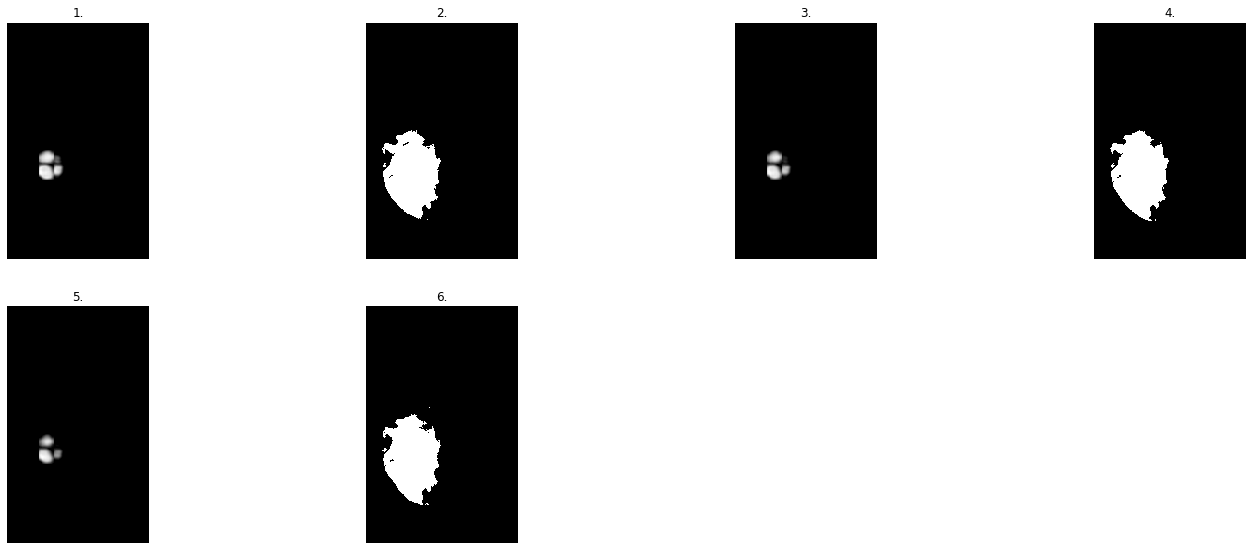

In [32]:
plt.figure(figsize=(25,20))
axial = 90
num = 4


plt.subplot(441)
plt.title('1.')
plt.axis('off')
plt.imshow(asd[axial, :, :],cmap='gray')



plt.subplot(442)
plt.title('2.')
plt.axis('off')
plt.imshow(label[axial, :, :], cmap='gray')

axial += 1

plt.subplot(443)
plt.title('3.')
plt.axis('off')
plt.imshow(asd[axial, :, :],cmap='gray')



plt.subplot(444)
plt.title('4.')
plt.axis('off')
plt.imshow(label[axial, :, :], cmap='gray')

axial += 1

plt.subplot(445)
plt.title('5.')
plt.axis('off')
plt.imshow(asd[ axial, :, :],cmap='gray')

plt.subplot(446)
plt.title('6.')
plt.axis('off')
plt.imshow(label[axial, :, :], cmap='gray')

plt.show()

In [9]:
#loss

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_val(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_ff = K.flatten(y_pred)
    y_pred_f = K.round(y_pred_ff)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [10]:
def u_net_3d(input_shape=None, 
             input_tensor=None,    
             convolutions=4, 
             dropout=.1, 
             num_outputs=1, 
             regression=True, 
             output_shape=None):

    
    initial_learning_rate=0.00001
    pool_size=(2, 2, 2)
    downsize_filters_factor=2
    filter_shape=(3, 3, 3)
    activation='relu'
    
    
    # This is messy, as is the part at the conclusion.
    if input_tensor is None:
        inputs = Input(input_shape)
    else:
        inputs = input_tensor

    conv1 = Conv3D(int(32/downsize_filters_factor), (3, 3, 3), activation=activation, data_format='channels_first', padding='same')(inputs)
    conv1 = Conv3D(int(64/downsize_filters_factor), (3, 3, 3), activation=activation, data_format='channels_first', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)                   
    pool1 = MaxPooling3D(pool_size=pool_size, data_format='channels_first',)(conv1)

    
    conv2 = Conv3D(int(64/downsize_filters_factor), (3, 3, 3), activation=activation,data_format='channels_first', padding='same')(pool1)   
    conv2 = Conv3D(int(128/downsize_filters_factor), (3, 3, 3), activation=activation,data_format='channels_first', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)  
    pool2 = MaxPooling3D(pool_size=pool_size, data_format='channels_first')(conv2)

    conv3 = Conv3D(int(128/downsize_filters_factor), (3, 3, 3), activation=activation,data_format='channels_first', padding='same')(pool2)
    conv3 = Conv3D(int(256/downsize_filters_factor), (3, 3, 3), activation=activation,data_format='channels_first', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)  
    pool3 = MaxPooling3D(pool_size=pool_size, data_format='channels_first')(conv3)

    conv4 = Conv3D(int(256/downsize_filters_factor), (3, 3, 3), activation=activation,data_format='channels_first', padding='same')(pool3)
     
    conv4 = Conv3D(int(512/downsize_filters_factor), (3, 3, 3), activation=activation,data_format='channels_first', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)  

    up5 = UpSampling3D(size=pool_size, data_format='channels_first')(conv4)
    up5 = concatenate([up5, conv3], axis=1)
    conv5 = Conv3D(int(256/downsize_filters_factor), (3, 3, 3), activation=activation, data_format='channels_first',padding='same')(up5)
    conv5 = Conv3D(int(256/downsize_filters_factor), (3, 3, 3), activation=activation,data_format='channels_first', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)  

    up6 = UpSampling3D(size=pool_size, data_format='channels_first')(conv5)
    up6 = concatenate([up6, conv2], axis=1)
    conv6 = Conv3D(int(128/downsize_filters_factor), (3, 3, 3), activation=activation,data_format='channels_first', padding='same')(up6)
    conv6 = Conv3D(int(128/downsize_filters_factor), (3, 3, 3), activation=activation,data_format='channels_first', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)  

    up7 = UpSampling3D(size=pool_size, data_format='channels_first')(conv6)
    up7 = concatenate([up7, conv1], axis=1)
    conv7 = Conv3D(int(64/downsize_filters_factor), (3, 3, 3), activation=activation,data_format='channels_first', padding='same')(up7)
    conv7 = Conv3D(int(64/downsize_filters_factor), (3, 3, 3), activation=activation,data_format='channels_first', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    conv8 = Conv3D(int(num_outputs), (1, 1, 1), data_format='channels_first',)(conv7)

    # Messy
    if input_tensor is not None:
        return conv8

    if regression:
        act = Activation('relu')(conv8)
        model = Model(inputs=inputs, outputs=act)
        model.compile(optimizer=Adam(lr=initial_learning_rate), loss=dice_coef_loss, metrics=[dice_coef_loss])
    else:
        if num_outputs == 1:
            act = Activation('sigmoid')(conv8)
            model = Model(inputs=inputs, outputs=act)
            model.compile(optimizer=Nadam(lr=initial_learning_rate), loss=dice_coef_loss, metrics=[dice_coef])
        else:
            act = Activation(image_softmax)(conv8)  # custom softmax for 4D tensor
            model = Model(inputs=inputs, outputs=act)
            model.compile(optimizer=Nadam(lr=initial_learning_rate), loss=image_categorical_crossentropy_loss,  # custom loss for 4D tensor
                          metrics=[image_categorical_crossentropy])

    return model

In [13]:
shape = (2,16,16,16)

model = u_net_3d(input_shape = shape)

In [22]:
shape = (2,16,16,16)
model = u_net_3d(input_shape = shape)

size = (16,16,16)

for i in range(1,400):
    pic_num = i
    img_from = pic_num-1
    img_until = pic_num


    img_full, label_full = t2_flair_load('D:/KBence/BRATS16_17/', '**/*.nii.gz', img_from, img_until)
    
    crop_img, crop_label = crop(image = img_full[0,:,:,:,:], label = label_full[0,:,:,:])

    patches, patches_label = patch(image = crop_img, label = crop_label, size = size, automat = True)

    batch_size = 4
    num_epochs = 4
    train_data = patches
    label_train = patches_label


    model.fit(x=train_data, y=label_train, batch_size=batch_size, verbose=1, epochs=num_epochs)

Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_001.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_001.nii.gz
bal levag: 51 pixelt
jobb levag: 186 pixelnel
a 3D kep uj alakja: (2, 155, 240, 151)
155 240 151 16 16 16
a label alapjan szükséges patchek száma: 54
a label összege: 111724.0
65.0 121.0 110.0
89.0 114.0 22.0
73.0 98.0 49.0
47.0 99.0 37.0
37.0 108.0 131.0
73.0 124.0 57.0
32.0 121.0 120.0
81.0 144.0 56.0
55.0 115.0 109.0
69.0 96.0 32.0
70.0 125.0 125.0
70.0 154.0 37.0
62.0 165.0 68.0
64.0 122.0 32.0
65.0 105.0 90.0
70.0 129.0 25.0
105.0 142.0 106.0
54.0 107.0 21.0
67.0 192.0 108.0
78.0 124.0 35.0
59.0 189.0 106.0
70.0 104.0 55.0
85.0 96.0 24.0
99.0 162.0 34.0
69.0 69.0 68.0
42.0 120.0 30.0
86.0 104.0 85.0
75.0 137.0 50.0
73.0 87.0 78.0
71.0 145.0 47.0
77.0 91.0 72.0
85.0 104.0 39.0
64.0 155.0 65.0
57.0 134.0 48.0
124.0 104.0 40.0
77.0 110.0 29.0
79.0 197.0 50.0
80.0 147.0 42.0
97.0 128.0 25.0
89.0 119.0 38.0
81.0 81.0 33.0
50.0 100.0 53.0
64.0 65.0 77.0
52.0 113.0 48

jobb levag: 190 pixelnel
a 3D kep uj alakja: (2, 155, 240, 159)
155 240 159 16 16 16
a label alapjan szükséges patchek száma: 106
a label összege: 217359.0
44.0 202.0 100.0
102.0 140.0 116.0
69.0 170.0 70.0
110.0 80.0 121.0
98.0 127.0 58.0
118.0 81.0 81.0
69.0 146.0 87.0
92.0 99.0 70.0
71.0 165.0 90.0
126.0 109.0 93.0
102.0 132.0 113.0
89.0 115.0 76.0
108.0 163.0 82.0
128.0 92.0 94.0
91.0 144.0 33.0
110.0 88.0 96.0
130.0 84.0 91.0
95.0 117.0 117.0
81.0 98.0 71.0
110.0 132.0 118.0
95.0 156.0 101.0
106.0 73.0 103.0
49.0 156.0 44.0
103.0 87.0 109.0
92.0 191.0 128.0
99.0 133.0 104.0
133.0 112.0 89.0
113.0 87.0 95.0
105.0 95.0 128.0
98.0 87.0 121.0
96.0 194.0 46.0
99.0 128.0 95.0
60.0 104.0 121.0
95.0 113.0 99.0
98.0 180.0 72.0
109.0 104.0 109.0
44.0 128.0 50.0
137.0 126.0 85.0
87.0 132.0 115.0
120.0 92.0 80.0
76.0 161.0 145.0
104.0 134.0 109.0
125.0 119.0 91.0
103.0 95.0 88.0
71.0 145.0 80.0
96.0 96.0 114.0
121.0 144.0 71.0
74.0 68.0 93.0
86.0 108.0 35.0
65.0 105.0 108.0
70.0 79.0 74.0
83.

Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_010.nii.gz
bal levag: 48 pixelt
jobb levag: 192 pixelnel
a 3D kep uj alakja: (2, 155, 240, 160)
155 240 160 16 16 16
a label alapjan szükséges patchek száma: 10
a label összege: 20487.0
122.0 116.0 106.0
86.0 168.0 121.0
95.0 158.0 25.0
99.0 179.0 109.0
53.0 132.0 89.0
77.0 165.0 114.0
87.0 137.0 109.0
81.0 163.0 123.0
45.0 136.0 95.0
94.0 170.0 123.0
Train on 10 samples
Epoch 1/4
10/10 [==============================] - 0s 9ms/sample - loss: -0.0286 - dice_coef_loss: -0.0274
Epoch 2/4
10/10 [==============================] - 0s 8ms/sample - loss: -0.1123 - dice_coef_loss: -0.0949  
Epoch 3/4
10/10 [==============================] - 0s 11ms/sample - loss: -0.4102 - dice_coef_loss: -0.3511
Epoch 4/4
10/10 [==============================] - 0s 8ms/sample - loss: -0.4982 - dice_coef_loss: -0.4655
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_011.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_011.nii.gz
bal levag: 52 pixelt
jo

96/96 [==============================] - 1s 7ms/sample - loss: -1.5285 - dice_coef_loss: -1.5285
Epoch 2/4
96/96 [==============================] - 1s 6ms/sample - loss: -1.5189 - dice_coef_loss: -1.5189
Epoch 3/4
96/96 [==============================] - 1s 6ms/sample - loss: -1.5274 - dice_coef_loss: -1.5274
Epoch 4/4
96/96 [==============================] - 1s 6ms/sample - loss: -1.6811 - dice_coef_loss: -1.6811
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_016.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_016.nii.gz
bal levag: 46 pixelt
jobb levag: 192 pixelnel
a 3D kep uj alakja: (2, 155, 240, 162)
155 240 162 16 16 16
a label alapjan szükséges patchek száma: 40
a label összege: 82728.0
74.0 144.0 87.0
62.0 120.0 140.0
53.0 116.0 48.0
78.0 108.0 113.0
51.0 198.0 77.0
48.0 127.0 127.0
45.0 163.0 123.0
83.0 123.0 119.0
71.0 131.0 53.0
70.0 148.0 114.0
83.0 76.0 112.0
64.0 120.0 129.0
121.0 153.0 107.0
51.0 134.0 126.0
80.0 128.0 94.0
41.0 108.0 128.0
92.0 156.0 60.0
63

124/124 [==============================] - 1s 6ms/sample - loss: -1.5822 - dice_coef_loss: -1.5822
Epoch 2/4
124/124 [==============================] - 1s 6ms/sample - loss: -1.5330 - dice_coef_loss: -1.5330
Epoch 3/4
124/124 [==============================] - 1s 6ms/sample - loss: -1.6589 - dice_coef_loss: -1.6589
Epoch 4/4
124/124 [==============================] - 1s 6ms/sample - loss: -1.5763 - dice_coef_loss: -1.5763
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_021.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_021.nii.gz
bal levag: 52 pixelt
jobb levag: 184 pixelnel
a 3D kep uj alakja: (2, 155, 240, 148)
155 240 148 16 16 16
a label alapjan szükséges patchek száma: 24
a label összege: 49639.0
67.0 143.0 107.0
60.0 148.0 69.0
66.0 177.0 41.0
71.0 135.0 81.0
57.0 115.0 15.0
61.0 149.0 78.0
54.0 160.0 15.0
73.0 129.0 48.0
87.0 174.0 88.0
54.0 143.0 81.0
95.0 177.0 36.0
65.0 147.0 78.0
123.0 102.0 95.0
57.0 130.0 58.0
74.0 200.0 69.0
81.0 126.0 65.0
64.0 100.0 117.0
46

30/30 [==============================] - 0s 8ms/sample - loss: -1.6974 - dice_coef_loss: -1.7009
Epoch 2/4
30/30 [==============================] - 0s 8ms/sample - loss: -1.7512 - dice_coef_loss: -1.7412
Epoch 3/4
30/30 [==============================] - 0s 8ms/sample - loss: -1.5139 - dice_coef_loss: -1.5314
Epoch 4/4
30/30 [==============================] - 0s 8ms/sample - loss: -1.6025 - dice_coef_loss: -1.5080
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_027.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_027.nii.gz
bal levag: 53 pixelt
jobb levag: 185 pixelnel
a 3D kep uj alakja: (2, 155, 240, 148)
155 240 148 16 16 16
a label alapjan szükséges patchek száma: 26
a label összege: 53274.0
89.0 104.0 63.0
93.0 97.0 103.0
37.0 179.0 26.0
100.0 112.0 111.0
80.0 82.0 69.0
83.0 124.0 125.0
102.0 159.0 68.0
93.0 98.0 120.0
70.0 104.0 23.0
108.0 130.0 118.0
91.0 192.0 39.0
109.0 103.0 113.0
65.0 132.0 48.0
115.0 99.0 111.0
30.0 113.0 99.0
88.0 128.0 104.0
44.0 148.0 16.0
110.

40/40 [==============================] - 0s 7ms/sample - loss: -1.3826 - dice_coef_loss: -1.3826
Epoch 2/4
40/40 [==============================] - 0s 6ms/sample - loss: -1.3483 - dice_coef_loss: -1.3483
Epoch 3/4
40/40 [==============================] - 0s 6ms/sample - loss: -1.5170 - dice_coef_loss: -1.5170
Epoch 4/4
40/40 [==============================] - 0s 6ms/sample - loss: -1.5709 - dice_coef_loss: -1.5709
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_038.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_038.nii.gz
bal levag: 51 pixelt
jobb levag: 185 pixelnel
a 3D kep uj alakja: (2, 155, 240, 150)
155 240 150 16 16 16
a label alapjan szükséges patchek száma: 72
a label összege: 150934.0
87.0 61.0 44.0
110.0 152.0 29.0
89.0 122.0 40.0
93.0 140.0 73.0
61.0 182.0 115.0
77.0 152.0 68.0
116.0 101.0 73.0
98.0 144.0 30.0
98.0 114.0 80.0
108.0 131.0 57.0
57.0 154.0 19.0
112.0 139.0 55.0
24.0 152.0 62.0
95.0 184.0 62.0
73.0 169.0 71.0
92.0 132.0 64.0
124.0 118.0 61.0
100.0 1

9.0 162.0 120.0
120.0 146.0 104.0
58.0 102.0 85.0
94.0 149.0 109.0
113.0 168.0 52.0
72.0 116.0 93.0
92.0 147.0 113.0
111.0 125.0 105.0
76.0 131.0 27.0
100.0 133.0 88.0
106.0 129.0 127.0
105.0 137.0 107.0
42.0 111.0 128.0
123.0 152.0 106.0
52.0 87.0 133.0
122.0 134.0 109.0
48.0 130.0 64.0
90.0 135.0 94.0
Train on 18 samples
Epoch 1/4
18/18 [==============================] - 0s 10ms/sample - loss: -1.2762 - dice_coef_loss: -1.1492
Epoch 2/4
18/18 [==============================] - 0s 9ms/sample - loss: -1.0861 - dice_coef_loss: -0.9886
Epoch 3/4
18/18 [==============================] - 0s 8ms/sample - loss: -1.6503 - dice_coef_loss: -1.6612
Epoch 4/4
18/18 [==============================] - 0s 9ms/sample - loss: -1.4603 - dice_coef_loss: -1.4846
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_044.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_044.nii.gz
bal levag: 46 pixelt
jobb levag: 192 pixelnel
a 3D kep uj alakja: (2, 155, 240, 162)
155 240 162 16 16 16
a label alapjan sz

Train on 78 samples
Epoch 1/4
78/78 [==============================] - 1s 8ms/sample - loss: -1.5423 - dice_coef_loss: -1.5445
Epoch 2/4
78/78 [==============================] - 1s 8ms/sample - loss: -1.6312 - dice_coef_loss: -1.5977
Epoch 3/4
78/78 [==============================] - 1s 8ms/sample - loss: -1.4463 - dice_coef_loss: -1.4282
Epoch 4/4
78/78 [==============================] - 1s 7ms/sample - loss: -1.6950 - dice_coef_loss: -1.6966
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_049.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_049.nii.gz
bal levag: 50 pixelt
jobb levag: 182 pixelnel
a 3D kep uj alakja: (2, 155, 240, 148)
155 240 148 16 16 16
a label alapjan szükséges patchek száma: 38
a label összege: 80312.0
99.0 181.0 60.0
68.0 122.0 94.0
98.0 123.0 61.0
75.0 131.0 112.0
94.0 132.0 99.0
72.0 133.0 110.0
48.0 92.0 42.0
52.0 146.0 100.0
96.0 123.0 67.0
72.0 138.0 122.0
70.0 137.0 121.0
52.0 108.0 95.0
82.0 117.0 23.0
53.0 117.0 97.0
48.0 133.0 110.0
50.0 122.0

62/62 [==============================] - 1s 8ms/sample - loss: -1.6006 - dice_coef_loss: -1.6032
Epoch 2/4
62/62 [==============================] - 0s 8ms/sample - loss: -1.7047 - dice_coef_loss: -1.7065
Epoch 3/4
62/62 [==============================] - 0s 8ms/sample - loss: -1.7303 - dice_coef_loss: -1.7327
Epoch 4/4
62/62 [==============================] - 0s 7ms/sample - loss: -1.5970 - dice_coef_loss: -1.5944
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_055.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_055.nii.gz
bal levag: 51 pixelt
jobb levag: 183 pixelnel
a 3D kep uj alakja: (2, 155, 240, 148)
155 240 148 16 16 16
a label alapjan szükséges patchek száma: 70
a label összege: 145414.0
57.0 123.0 73.0
90.0 139.0 56.0
73.0 160.0 102.0
80.0 138.0 54.0
25.0 157.0 74.0
110.0 155.0 67.0
74.0 151.0 66.0
110.0 158.0 68.0
53.0 195.0 88.0
94.0 161.0 60.0
97.0 132.0 59.0
87.0 177.0 53.0
125.0 131.0 103.0
88.0 157.0 26.0
102.0 74.0 53.0
70.0 143.0 50.0
60.0 105.0 129.0
115.0 

155 240 151 16 16 16
a label alapjan szükséges patchek száma: 48
a label összege: 99569.0
92.0 148.0 36.0
95.0 98.0 58.0
28.0 119.0 25.0
61.0 58.0 76.0
20.0 162.0 87.0
108.0 83.0 67.0
53.0 102.0 136.0
79.0 83.0 40.0
56.0 156.0 64.0
91.0 103.0 65.0
69.0 81.0 71.0
60.0 56.0 76.0
51.0 158.0 104.0
90.0 79.0 42.0
30.0 148.0 41.0
99.0 52.0 68.0
67.0 71.0 84.0
98.0 91.0 67.0
95.0 195.0 59.0
82.0 67.0 84.0
113.0 131.0 125.0
79.0 94.0 66.0
74.0 110.0 132.0
64.0 100.0 73.0
62.0 80.0 96.0
86.0 77.0 49.0
110.0 97.0 53.0
61.0 66.0 81.0
123.0 131.0 40.0
69.0 96.0 67.0
41.0 159.0 113.0
70.0 77.0 41.0
12.0 173.0 95.0
85.0 46.0 63.0
25.0 128.0 45.0
89.0 69.0 69.0
86.0 51.0 70.0
82.0 77.0 41.0
106.0 95.0 102.0
102.0 81.0 48.0
45.0 155.0 121.0
84.0 86.0 39.0
26.0 170.0 108.0
88.0 49.0 73.0
55.0 112.0 112.0
84.0 58.0 59.0
123.0 149.0 56.0
99.0 53.0 71.0
Train on 48 samples
Epoch 1/4
48/48 [==============================] - 0s 7ms/sample - loss: -1.5330 - dice_coef_loss: -1.5330
Epoch 2/4
48/48 [==========

86/86 [==============================] - 1s 8ms/sample - loss: -1.6603 - dice_coef_loss: -1.6633
Epoch 2/4
86/86 [==============================] - 1s 8ms/sample - loss: -1.6678 - dice_coef_loss: -1.6704
Epoch 3/4
86/86 [==============================] - 1s 8ms/sample - loss: -1.6439 - dice_coef_loss: -1.6066
Epoch 4/4
86/86 [==============================] - 1s 8ms/sample - loss: -1.6863 - dice_coef_loss: -1.6497
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_065.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_065.nii.gz
bal levag: 46 pixelt
jobb levag: 193 pixelnel
a 3D kep uj alakja: (2, 155, 240, 163)
155 240 163 16 16 16
a label alapjan szükséges patchek száma: 80
a label összege: 166091.0
102.0 155.0 122.0
107.0 89.0 34.0
38.0 107.0 127.0
93.0 76.0 44.0
80.0 106.0 81.0
64.0 86.0 85.0
22.0 168.0 85.0
53.0 86.0 113.0
92.0 59.0 45.0
101.0 92.0 45.0
77.0 103.0 72.0
79.0 103.0 75.0
89.0 204.0 52.0
52.0 86.0 105.0
62.0 69.0 57.0
70.0 100.0 42.0
72.0 63.0 110.0
105.0 71.0 46

60/60 [==============================] - 0s 7ms/sample - loss: -1.6736 - dice_coef_loss: -1.6736
Epoch 2/4
60/60 [==============================] - 0s 7ms/sample - loss: -1.7042 - dice_coef_loss: -1.7042
Epoch 3/4
60/60 [==============================] - 0s 6ms/sample - loss: -1.6129 - dice_coef_loss: -1.6129
Epoch 4/4
60/60 [==============================] - 0s 6ms/sample - loss: -1.6850 - dice_coef_loss: -1.6850
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_076.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_076.nii.gz
bal levag: 51 pixelt
jobb levag: 183 pixelnel
a 3D kep uj alakja: (2, 155, 240, 148)
155 240 148 16 16 16
a label alapjan szükséges patchek száma: 98
a label összege: 200985.0
74.0 139.0 83.0
93.0 100.0 26.0
71.0 185.0 84.0
51.0 117.0 25.0
48.0 184.0 55.0
72.0 125.0 81.0
111.0 76.0 97.0
111.0 104.0 57.0
81.0 122.0 93.0
62.0 123.0 61.0
124.0 114.0 102.0
96.0 142.0 44.0
47.0 94.0 48.0
81.0 100.0 59.0
78.0 193.0 32.0
68.0 100.0 30.0
66.0 147.0 14.0
101.0 119.

60/60 [==============================] - 0s 7ms/sample - loss: -1.5593 - dice_coef_loss: -1.5593
Epoch 2/4
60/60 [==============================] - 0s 6ms/sample - loss: -1.6134 - dice_coef_loss: -1.6134
Epoch 3/4
60/60 [==============================] - 0s 7ms/sample - loss: -1.6406 - dice_coef_loss: -1.6406
Epoch 4/4
60/60 [==============================] - 0s 7ms/sample - loss: -1.5276 - dice_coef_loss: -1.5276
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_087.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_087.nii.gz
bal levag: 49 pixelt
jobb levag: 188 pixelnel
a 3D kep uj alakja: (2, 155, 240, 155)
155 240 155 16 16 16
a label alapjan szükséges patchek száma: 30
a label összege: 64878.0
55.0 106.0 127.0
80.0 99.0 100.0
44.0 143.0 142.0
94.0 116.0 118.0
84.0 176.0 43.0
70.0 115.0 115.0
58.0 151.0 29.0
96.0 117.0 102.0
105.0 130.0 117.0
90.0 148.0 94.0
75.0 128.0 90.0
55.0 115.0 49.0
55.0 192.0 81.0
78.0 106.0 108.0
24.0 171.0 88.0
94.0 98.0 95.0
49.0 141.0 52.0
82.0 1

155 240 159 16 16 16
a label alapjan szükséges patchek száma: 76
a label összege: 157285.0
46.0 142.0 132.0
75.0 116.0 99.0
93.0 143.0 64.0
104.0 139.0 106.0
122.0 88.0 88.0
83.0 102.0 127.0
123.0 161.0 63.0
94.0 78.0 100.0
41.0 108.0 51.0
115.0 85.0 103.0
92.0 69.0 61.0
73.0 109.0 106.0
75.0 53.0 104.0
73.0 118.0 110.0
64.0 167.0 56.0
107.0 93.0 85.0
40.0 171.0 83.0
96.0 95.0 94.0
106.0 72.0 49.0
83.0 110.0 102.0
121.0 111.0 107.0
86.0 64.0 113.0
42.0 186.0 125.0
79.0 76.0 120.0
83.0 124.0 121.0
89.0 73.0 126.0
86.0 65.0 75.0
99.0 130.0 124.0
92.0 104.0 66.0
83.0 115.0 89.0
79.0 119.0 45.0
83.0 114.0 82.0
57.0 80.0 123.0
125.0 109.0 87.0
100.0 67.0 94.0
78.0 87.0 104.0
126.0 100.0 72.0
107.0 126.0 92.0
21.0 109.0 124.0
110.0 93.0 112.0
58.0 113.0 132.0
86.0 120.0 130.0
43.0 108.0 117.0
113.0 84.0 97.0
28.0 186.0 59.0
97.0 83.0 99.0
70.0 116.0 43.0
105.0 144.0 105.0
74.0 57.0 65.0
88.0 126.0 92.0
70.0 195.0 69.0
76.0 118.0 103.0
70.0 73.0 117.0
107.0 72.0 103.0
43.0 119.0 113.0
113.0 7

Epoch 2/4
16/16 [==============================] - 0s 7ms/sample - loss: -1.6890 - dice_coef_loss: -1.6890
Epoch 3/4
16/16 [==============================] - 0s 6ms/sample - loss: -1.7484 - dice_coef_loss: -1.7484
Epoch 4/4
16/16 [==============================] - 0s 6ms/sample - loss: -1.7010 - dice_coef_loss: -1.7010
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_096.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_096.nii.gz
bal levag: 53 pixelt
jobb levag: 182 pixelnel
a 3D kep uj alakja: (2, 155, 240, 145)
155 240 145 16 16 16
a label alapjan szükséges patchek száma: 36
a label összege: 76255.0
73.0 148.0 133.0
74.0 149.0 99.0
50.0 190.0 59.0
81.0 111.0 98.0
101.0 69.0 86.0
65.0 107.0 109.0
90.0 174.0 42.0
58.0 121.0 102.0
65.0 93.0 112.0
66.0 104.0 107.0
106.0 103.0 32.0
66.0 138.0 108.0
63.0 203.0 92.0
32.0 114.0 101.0
71.0 121.0 126.0
75.0 118.0 90.0
27.0 152.0 39.0
71.0 112.0 117.0
64.0 147.0 26.0
61.0 126.0 94.0
95.0 104.0 43.0
47.0 125.0 123.0
44.0 122.0 85.0
61.0

155 240 168 16 16 16
a label alapjan szükséges patchek száma: 40
a label összege: 83568.0
81.0 79.0 71.0
122.0 144.0 116.0
108.0 125.0 71.0
119.0 116.0 140.0
113.0 122.0 136.0
119.0 155.0 128.0
104.0 155.0 93.0
115.0 117.0 116.0
114.0 146.0 18.0
124.0 130.0 127.0
113.0 70.0 51.0
115.0 140.0 108.0
84.0 164.0 40.0
118.0 145.0 110.0
136.0 161.0 95.0
115.0 139.0 103.0
124.0 122.0 133.0
105.0 137.0 111.0
65.0 165.0 46.0
101.0 135.0 104.0
111.0 119.0 100.0
107.0 123.0 138.0
134.0 177.0 71.0
119.0 124.0 144.0
118.0 154.0 71.0
102.0 118.0 135.0
79.0 170.0 59.0
119.0 73.0 95.0
82.0 183.0 40.0
118.0 142.0 119.0
79.0 119.0 128.0
105.0 133.0 120.0
117.0 142.0 22.0
111.0 65.0 91.0
61.0 119.0 41.0
113.0 156.0 111.0
68.0 149.0 112.0
114.0 124.0 112.0
97.0 161.0 153.0
112.0 119.0 116.0
Train on 40 samples
Epoch 1/4
40/40 [==============================] - 0s 7ms/sample - loss: -1.2688 - dice_coef_loss: -1.2688
Epoch 2/4
40/40 [==============================] - 0s 6ms/sample - loss: -1.1590 - dice_coef

155 240 151 16 16 16
a label alapjan szükséges patchek száma: 48
a label összege: 99803.0
104.0 79.0 44.0
74.0 83.0 46.0
79.0 180.0 71.0
78.0 178.0 48.0
71.0 176.0 107.0
89.0 167.0 57.0
64.0 60.0 75.0
61.0 86.0 61.0
82.0 140.0 28.0
93.0 139.0 46.0
30.0 100.0 40.0
49.0 174.0 43.0
60.0 125.0 49.0
86.0 129.0 27.0
102.0 169.0 58.0
59.0 63.0 74.0
74.0 94.0 127.0
106.0 145.0 46.0
73.0 191.0 115.0
91.0 117.0 34.0
100.0 138.0 82.0
92.0 129.0 36.0
32.0 197.0 105.0
50.0 96.0 49.0
65.0 184.0 27.0
45.0 101.0 54.0
68.0 66.0 120.0
50.0 98.0 49.0
86.0 90.0 41.0
59.0 86.0 53.0
88.0 126.0 85.0
66.0 94.0 74.0
72.0 149.0 111.0
67.0 193.0 55.0
50.0 165.0 47.0
87.0 115.0 43.0
81.0 151.0 96.0
51.0 178.0 48.0
59.0 191.0 111.0
67.0 95.0 74.0
108.0 96.0 44.0
81.0 117.0 32.0
100.0 154.0 40.0
38.0 109.0 46.0
97.0 118.0 40.0
40.0 127.0 31.0
33.0 169.0 99.0
79.0 108.0 35.0
Train on 48 samples
Epoch 1/4
48/48 [==============================] - 0s 7ms/sample - loss: -1.3025 - dice_coef_loss: -1.3025
Epoch 2/4
48/48 

Train on 82 samples
Epoch 1/4
82/82 [==============================] - 1s 8ms/sample - loss: -1.7139 - dice_coef_loss: -1.6732
Epoch 2/4
82/82 [==============================] - 1s 8ms/sample - loss: -1.6112 - dice_coef_loss: -1.6167
Epoch 3/4
82/82 [==============================] - 1s 7ms/sample - loss: -1.7631 - dice_coef_loss: -1.7211
Epoch 4/4
82/82 [==============================] - 1s 8ms/sample - loss: -1.8111 - dice_coef_loss: -1.8114
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_113.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_113.nii.gz
bal levag: 51 pixelt
jobb levag: 192 pixelnel
a 3D kep uj alakja: (2, 155, 240, 157)
155 240 157 16 16 16
a label alapjan szükséges patchek száma: 78
a label összege: 159809.0
95.0 82.0 65.0
119.0 128.0 104.0
65.0 127.0 124.0
85.0 172.0 78.0
88.0 167.0 118.0
87.0 178.0 82.0
101.0 148.0 88.0
93.0 115.0 90.0
73.0 153.0 76.0
107.0 143.0 98.0
85.0 139.0 86.0
77.0 145.0 129.0
52.0 172.0 24.0
82.0 140.0 119.0
46.0 115.0 83.0
72.0 15

62.0 174.0 49.0
40.0 155.0 105.0
82.0 125.0 27.0
66.0 160.0 108.0
115.0 160.0 42.0
79.0 101.0 100.0
70.0 121.0 60.0
79.0 110.0 114.0
80.0 91.0 68.0
87.0 162.0 107.0
52.0 106.0 47.0
84.0 154.0 92.0
68.0 177.0 107.0
74.0 94.0 103.0
50.0 210.0 97.0
105.0 93.0 93.0
109.0 159.0 56.0
104.0 75.0 85.0
102.0 104.0 114.0
71.0 184.0 107.0
109.0 153.0 109.0
67.0 162.0 103.0
62.0 201.0 44.0
64.0 139.0 127.0
119.0 162.0 98.0
93.0 170.0 90.0
91.0 93.0 56.0
56.0 188.0 91.0
123.0 92.0 43.0
78.0 158.0 97.0
25.0 154.0 96.0
57.0 148.0 115.0
51.0 203.0 82.0
66.0 174.0 88.0
63.0 75.0 52.0
97.0 99.0 75.0
90.0 136.0 130.0
76.0 96.0 69.0
83.0 56.0 108.0
74.0 111.0 94.0
98.0 94.0 25.0
72.0 130.0 119.0
59.0 150.0 44.0
63.0 146.0 91.0
129.0 182.0 79.0
72.0 147.0 101.0
77.0 144.0 58.0
49.0 179.0 106.0
58.0 131.0 75.0
74.0 115.0 119.0
61.0 115.0 65.0
66.0 149.0 103.0
76.0 65.0 41.0
67.0 98.0 96.0
65.0 152.0 73.0
58.0 168.0 89.0
110.0 95.0 46.0
76.0 95.0 65.0
65.0 135.0 51.0
44.0 161.0 107.0
69.0 207.0 82.0
69.0 187

42.0 198.0 89.0
118.0 167.0 52.0
118.0 164.0 94.0
59.0 167.0 103.0
65.0 97.0 30.0
52.0 139.0 129.0
75.0 69.0 79.0
107.0 168.0 56.0
100.0 83.0 109.0
50.0 136.0 122.0
93.0 189.0 61.0
111.0 156.0 34.0
91.0 91.0 90.0
81.0 160.0 30.0
64.0 139.0 39.0
73.0 182.0 123.0
29.0 121.0 74.0
55.0 149.0 82.0
92.0 119.0 23.0
80.0 109.0 121.0
15.0 158.0 115.0
57.0 189.0 118.0
79.0 138.0 96.0
96.0 157.0 29.0
118.0 159.0 77.0
39.0 122.0 125.0
68.0 183.0 97.0
114.0 157.0 38.0
100.0 184.0 99.0
69.0 154.0 123.0
92.0 85.0 97.0
78.0 184.0 107.0
69.0 73.0 89.0
54.0 149.0 118.0
96.0 184.0 55.0
88.0 177.0 33.0
66.0 159.0 68.0
86.0 152.0 55.0
108.0 120.0 48.0
73.0 168.0 44.0
100.0 152.0 85.0
73.0 159.0 50.0
127.0 148.0 87.0
52.0 115.0 128.0
90.0 120.0 117.0
55.0 176.0 126.0
36.0 123.0 87.0
74.0 154.0 59.0
107.0 112.0 34.0
71.0 165.0 98.0
35.0 144.0 72.0
107.0 168.0 50.0
44.0 108.0 60.0
72.0 165.0 102.0
67.0 116.0 37.0
106.0 149.0 44.0
74.0 67.0 79.0
101.0 136.0 47.0
58.0 119.0 110.0
79.0 175.0 122.0
67.0 106.0 25.

Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_128.nii.gz
bal levag: 51 pixelt
jobb levag: 186 pixelnel
a 3D kep uj alakja: (2, 155, 240, 151)
155 240 151 16 16 16
a label alapjan szükséges patchek száma: 10
a label összege: 20866.0
93.0 164.0 118.0
76.0 79.0 102.0
17.0 170.0 99.0
84.0 75.0 88.0
56.0 180.0 128.0
93.0 81.0 102.0
77.0 81.0 117.0
82.0 74.0 92.0
99.0 89.0 52.0
100.0 85.0 87.0
Train on 10 samples
Epoch 1/4
10/10 [==============================] - 0s 11ms/sample - loss: -1.4382 - dice_coef_loss: -1.1985
Epoch 2/4
10/10 [==============================] - 0s 9ms/sample - loss: -1.7948 - dice_coef_loss: -1.8006
Epoch 3/4
10/10 [==============================] - 0s 9ms/sample - loss: -1.7421 - dice_coef_loss: -1.7569
Epoch 4/4
10/10 [==============================] - 0s 9ms/sample - loss: -1.8100 - dice_coef_loss: -1.7978
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_129.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_129.nii.gz
bal levag: 48 pixelt
jobb levag: 1

Epoch 1/4
28/28 [==============================] - 0s 7ms/sample - loss: -1.2248 - dice_coef_loss: -1.2248
Epoch 2/4
28/28 [==============================] - 0s 7ms/sample - loss: -1.4384 - dice_coef_loss: -1.4384
Epoch 3/4
28/28 [==============================] - 0s 7ms/sample - loss: -1.6182 - dice_coef_loss: -1.6182
Epoch 4/4
28/28 [==============================] - 0s 7ms/sample - loss: -1.6637 - dice_coef_loss: -1.6637
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_134.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_134.nii.gz
bal levag: 51 pixelt
jobb levag: 191 pixelnel
a 3D kep uj alakja: (2, 155, 240, 156)
155 240 156 16 16 16
a label alapjan szükséges patchek száma: 28
a label összege: 59141.0
57.0 205.0 88.0
52.0 133.0 119.0
83.0 193.0 54.0
63.0 131.0 126.0
61.0 105.0 44.0
67.0 127.0 108.0
108.0 179.0 47.0
38.0 114.0 131.0
41.0 197.0 96.0
77.0 161.0 106.0
56.0 125.0 75.0
42.0 102.0 130.0
35.0 182.0 121.0
61.0 139.0 112.0
68.0 132.0 49.0
53.0 101.0 128.0
59.0 191.

40/40 [==============================] - 0s 7ms/sample - loss: -1.3249 - dice_coef_loss: -1.3249
Epoch 2/4
40/40 [==============================] - 0s 6ms/sample - loss: -1.4645 - dice_coef_loss: -1.4645
Epoch 3/4
40/40 [==============================] - 0s 7ms/sample - loss: -1.4346 - dice_coef_loss: -1.4346
Epoch 4/4
40/40 [==============================] - 0s 6ms/sample - loss: -1.5139 - dice_coef_loss: -1.5139
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_140.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_140.nii.gz
bal levag: 51 pixelt
jobb levag: 188 pixelnel
a 3D kep uj alakja: (2, 155, 240, 153)
155 240 153 16 16 16
a label alapjan szükséges patchek száma: 82
a label összege: 170107.0
67.0 148.0 19.0
71.0 131.0 33.0
51.0 186.0 42.0
106.0 172.0 39.0
23.0 128.0 82.0
56.0 197.0 59.0
101.0 184.0 105.0
57.0 112.0 50.0
45.0 174.0 54.0
52.0 122.0 44.0
86.0 183.0 32.0
79.0 155.0 48.0
91.0 160.0 41.0
81.0 138.0 37.0
131.0 111.0 90.0
97.0 155.0 45.0
79.0 109.0 70.0
86.0 194

56/56 [==============================] - 0s 7ms/sample - loss: -1.6564 - dice_coef_loss: -1.6564
Epoch 2/4
56/56 [==============================] - 0s 6ms/sample - loss: -1.6267 - dice_coef_loss: -1.6267
Epoch 3/4
56/56 [==============================] - 0s 6ms/sample - loss: -1.8037 - dice_coef_loss: -1.8037
Epoch 4/4
56/56 [==============================] - 0s 6ms/sample - loss: -1.7758 - dice_coef_loss: -1.7758
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_144.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_144.nii.gz
bal levag: 47 pixelt
jobb levag: 192 pixelnel
a 3D kep uj alakja: (2, 155, 240, 161)
155 240 161 16 16 16
a label alapjan szükséges patchek száma: 24
a label összege: 51296.0
30.0 157.0 106.0
123.0 165.0 57.0
116.0 135.0 79.0
103.0 159.0 78.0
98.0 152.0 136.0
85.0 157.0 63.0
117.0 76.0 95.0
122.0 156.0 79.0
52.0 192.0 55.0
117.0 168.0 72.0
102.0 126.0 86.0
106.0 179.0 72.0
85.0 201.0 50.0
113.0 142.0 77.0
97.0 92.0 83.0
109.0 158.0 55.0
55.0 87.0 119.0
91.

60/60 [==============================] - 0s 7ms/sample - loss: -1.5470 - dice_coef_loss: -1.5470
Epoch 2/4
60/60 [==============================] - 0s 6ms/sample - loss: -1.5913 - dice_coef_loss: -1.5913
Epoch 3/4
60/60 [==============================] - 0s 6ms/sample - loss: -1.6036 - dice_coef_loss: -1.6036
Epoch 4/4
60/60 [==============================] - 0s 6ms/sample - loss: -1.7835 - dice_coef_loss: -1.7835
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_150.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_150.nii.gz
bal levag: 50 pixelt
jobb levag: 192 pixelnel
a 3D kep uj alakja: (2, 155, 240, 158)
155 240 158 16 16 16
a label alapjan szükséges patchek száma: 70
a label összege: 143796.0
68.0 178.0 43.0
85.0 147.0 108.0
41.0 184.0 45.0
115.0 118.0 114.0
89.0 113.0 87.0
101.0 126.0 128.0
86.0 125.0 68.0
111.0 97.0 96.0
82.0 162.0 23.0
112.0 118.0 109.0
48.0 122.0 29.0
82.0 124.0 112.0
32.0 108.0 108.0
111.0 133.0 100.0
80.0 114.0 18.0
96.0 134.0 114.0
10.0 136.0 57.0


70.0 72.0 128.0
64.0 140.0 107.0
52.0 117.0 65.0
85.0 92.0 105.0
87.0 156.0 44.0
48.0 150.0 101.0
60.0 128.0 136.0
73.0 170.0 96.0
128.0 135.0 85.0
63.0 184.0 100.0
48.0 161.0 80.0
56.0 145.0 103.0
115.0 76.0 72.0
74.0 165.0 102.0
63.0 89.0 57.0
44.0 148.0 106.0
90.0 101.0 111.0
92.0 94.0 87.0
26.0 192.0 119.0
52.0 155.0 109.0
110.0 119.0 70.0
82.0 84.0 105.0
28.0 152.0 131.0
51.0 157.0 103.0
110.0 156.0 52.0
38.0 108.0 115.0
8.0 173.0 62.0
80.0 101.0 100.0
93.0 198.0 80.0
89.0 101.0 115.0
80.0 98.0 120.0
55.0 166.0 118.0
33.0 127.0 58.0
100.0 105.0 96.0
87.0 169.0 37.0
37.0 136.0 108.0
42.0 108.0 63.0
91.0 89.0 101.0
23.0 153.0 78.0
54.0 154.0 123.0
56.0 164.0 102.0
104.0 90.0 92.0
55.0 150.0 104.0
89.0 82.0 107.0
45.0 113.0 52.0
55.0 147.0 87.0
Train on 46 samples
Epoch 1/4
46/46 [==============================] - 0s 8ms/sample - loss: -1.6067 - dice_coef_loss: -1.6136
Epoch 2/4
46/46 [==============================] - 0s 8ms/sample - loss: -1.5670 - dice_coef_loss: -1.5696
Epoch 3/4

Train on 86 samples
Epoch 1/4
86/86 [==============================] - 1s 8ms/sample - loss: -1.5062 - dice_coef_loss: -1.5119
Epoch 2/4
86/86 [==============================] - 1s 7ms/sample - loss: -1.6358 - dice_coef_loss: -1.6217
Epoch 3/4
86/86 [==============================] - 1s 8ms/sample - loss: -1.5447 - dice_coef_loss: -1.5507
Epoch 4/4
86/86 [==============================] - 1s 7ms/sample - loss: -1.5143 - dice_coef_loss: -1.5192
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_158.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_158.nii.gz
bal levag: 51 pixelt
jobb levag: 186 pixelnel
a 3D kep uj alakja: (2, 155, 240, 151)
155 240 151 16 16 16
a label alapjan szükséges patchek száma: 24
a label összege: 49235.0
52.0 129.0 51.0
75.0 154.0 115.0
126.0 133.0 91.0
53.0 169.0 104.0
66.0 179.0 78.0
63.0 164.0 104.0
19.0 164.0 30.0
83.0 160.0 114.0
57.0 62.0 80.0
83.0 157.0 121.0
103.0 116.0 19.0
69.0 144.0 110.0
103.0 102.0 87.0
56.0 148.0 116.0
71.0 152.0 97.0
68.0 1

Train on 38 samples
Epoch 1/4
38/38 [==============================] - 0s 8ms/sample - loss: -1.4874 - dice_coef_loss: -1.4130
Epoch 2/4
38/38 [==============================] - 0s 8ms/sample - loss: -1.7209 - dice_coef_loss: -1.7163
Epoch 3/4
38/38 [==============================] - 0s 8ms/sample - loss: -1.6591 - dice_coef_loss: -1.6595
Epoch 4/4
38/38 [==============================] - 0s 8ms/sample - loss: -1.6387 - dice_coef_loss: -1.6491
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_164.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_164.nii.gz
bal levag: 50 pixelt
jobb levag: 186 pixelnel
a 3D kep uj alakja: (2, 155, 240, 152)
155 240 152 16 16 16
a label alapjan szükséges patchek száma: 34
a label összege: 73590.0
65.0 154.0 128.0
77.0 187.0 101.0
107.0 189.0 89.0
116.0 179.0 91.0
100.0 183.0 77.0
70.0 179.0 119.0
83.0 120.0 87.0
85.0 180.0 112.0
47.0 102.0 61.0
104.0 188.0 91.0
60.0 144.0 125.0
104.0 180.0 111.0
93.0 81.0 35.0
72.0 161.0 112.0
92.0 110.0 96.0
60.0

Train on 42 samples
Epoch 1/4
42/42 [==============================] - 0s 8ms/sample - loss: -0.8355 - dice_coef_loss: -0.7976
Epoch 2/4
42/42 [==============================] - 0s 8ms/sample - loss: -1.1285 - dice_coef_loss: -1.1509
Epoch 3/4
42/42 [==============================] - 0s 8ms/sample - loss: -1.5030 - dice_coef_loss: -1.5161
Epoch 4/4
42/42 [==============================] - 0s 8ms/sample - loss: -1.6797 - dice_coef_loss: -1.6762
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_170.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_170.nii.gz
bal levag: 48 pixelt
jobb levag: 187 pixelnel
a 3D kep uj alakja: (2, 155, 240, 155)
155 240 155 16 16 16
a label alapjan szükséges patchek száma: 76
a label összege: 159157.0
76.0 55.0 51.0
118.0 115.0 95.0
122.0 110.0 61.0
95.0 104.0 112.0
17.0 163.0 105.0
104.0 84.0 84.0
61.0 71.0 66.0
120.0 135.0 115.0
126.0 116.0 87.0
103.0 104.0 76.0
63.0 119.0 115.0
83.0 118.0 107.0
37.0 166.0 75.0
113.0 129.0 99.0
114.0 89.0 81.0
119.0

Train on 50 samples
Epoch 1/4
50/50 [==============================] - 0s 8ms/sample - loss: -1.7592 - dice_coef_loss: -1.7625
Epoch 2/4
50/50 [==============================] - 0s 8ms/sample - loss: -1.6527 - dice_coef_loss: -1.6602
Epoch 3/4
50/50 [==============================] - 0s 8ms/sample - loss: -1.8437 - dice_coef_loss: -1.8441
Epoch 4/4
50/50 [==============================] - 0s 8ms/sample - loss: -1.7990 - dice_coef_loss: -1.7977
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_175.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_175.nii.gz
bal levag: 51 pixelt
jobb levag: 184 pixelnel
a 3D kep uj alakja: (2, 155, 240, 149)
155 240 149 16 16 16
a label alapjan szükséges patchek száma: 4
a label összege: 8478.0
97.0 83.0 36.0
62.0 132.0 31.0
72.0 82.0 53.0
58.0 129.0 27.0
Train on 4 samples
Epoch 1/4
4/4 [==============================] - 0s 8ms/sample - loss: -1.6154 - dice_coef_loss: -1.6154
Epoch 2/4
4/4 [==============================] - 0s 8ms/sample - loss: 

44.0 88.0 52.0
92.0 107.0 50.0
65.0 174.0 49.0
103.0 93.0 70.0
60.0 103.0 65.0
123.0 105.0 48.0
107.0 158.0 45.0
103.0 92.0 58.0
93.0 144.0 42.0
116.0 115.0 59.0
113.0 134.0 103.0
93.0 98.0 34.0
99.0 170.0 49.0
86.0 107.0 41.0
114.0 141.0 121.0
113.0 98.0 68.0
27.0 178.0 58.0
93.0 98.0 30.0
Train on 18 samples
Epoch 1/4
18/18 [==============================] - 0s 10ms/sample - loss: -1.3527 - dice_coef_loss: -1.2177
Epoch 2/4
18/18 [==============================] - 0s 9ms/sample - loss: -1.5187 - dice_coef_loss: -1.5409
Epoch 3/4
18/18 [==============================] - 0s 9ms/sample - loss: -1.2248 - dice_coef_loss: -1.2455
Epoch 4/4
18/18 [==============================] - 0s 8ms/sample - loss: -1.4357 - dice_coef_loss: -1.4628
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_190.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_190.nii.gz
bal levag: 51 pixelt
jobb levag: 185 pixelnel
a 3D kep uj alakja: (2, 155, 240, 150)
155 240 150 16 16 16
a label alapjan szükséges patch

Train on 26 samples
Epoch 1/4
26/26 [==============================] - 0s 8ms/sample - loss: -1.3005 - dice_coef_loss: -1.3274
Epoch 2/4
26/26 [==============================] - 0s 8ms/sample - loss: -1.4909 - dice_coef_loss: -1.5161
Epoch 3/4
26/26 [==============================] - 0s 7ms/sample - loss: -1.7388 - dice_coef_loss: -1.7445
Epoch 4/4
26/26 [==============================] - 0s 8ms/sample - loss: -1.6594 - dice_coef_loss: -1.5459
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_200.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_200.nii.gz
bal levag: 51 pixelt
jobb levag: 186 pixelnel
a 3D kep uj alakja: (2, 155, 240, 151)
155 240 151 16 16 16
a label alapjan szükséges patchek száma: 76
a label összege: 159249.0
60.0 119.0 85.0
88.0 139.0 48.0
37.0 135.0 81.0
76.0 145.0 63.0
83.0 157.0 73.0
78.0 127.0 45.0
45.0 107.0 110.0
72.0 113.0 49.0
70.0 192.0 92.0
85.0 123.0 37.0
108.0 143.0 55.0
61.0 95.0 62.0
62.0 156.0 106.0
62.0 139.0 41.0
49.0 150.0 126.0
86.0 103.0 

98/98 [==============================] - 1s 8ms/sample - loss: -1.5769 - dice_coef_loss: -1.5799
Epoch 2/4
98/98 [==============================] - 1s 8ms/sample - loss: -1.6651 - dice_coef_loss: -1.6414
Epoch 3/4
98/98 [==============================] - 1s 7ms/sample - loss: -1.6045 - dice_coef_loss: -1.5869
Epoch 4/4
98/98 [==============================] - 1s 7ms/sample - loss: -1.6604 - dice_coef_loss: -1.6629
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_208.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_208.nii.gz
bal levag: 49 pixelt
jobb levag: 186 pixelnel
a 3D kep uj alakja: (2, 155, 240, 153)
155 240 153 16 16 16
a label alapjan szükséges patchek száma: 32
a label összege: 66754.0
88.0 73.0 60.0
74.0 138.0 121.0
97.0 95.0 123.0
53.0 138.0 114.0
61.0 148.0 41.0
76.0 116.0 137.0
80.0 68.0 68.0
55.0 161.0 110.0
63.0 198.0 77.0
50.0 124.0 127.0
84.0 103.0 115.0
70.0 151.0 115.0
85.0 125.0 67.0
61.0 161.0 119.0
110.0 159.0 128.0
66.0 154.0 119.0
65.0 204.0 88.0
59.0

155 240 148 16 16 16
a label alapjan szükséges patchek száma: 48
a label összege: 100554.0
82.0 84.0 110.0
88.0 160.0 116.0
107.0 156.0 118.0
80.0 167.0 91.0
94.0 157.0 13.0
82.0 158.0 102.0
31.0 165.0 91.0
79.0 170.0 94.0
122.0 179.0 96.0
99.0 136.0 84.0
83.0 161.0 36.0
80.0 118.0 109.0
67.0 130.0 12.0
70.0 118.0 105.0
26.0 140.0 59.0
69.0 155.0 85.0
104.0 95.0 120.0
74.0 126.0 109.0
121.0 92.0 61.0
84.0 143.0 83.0
88.0 104.0 113.0
102.0 142.0 87.0
73.0 143.0 53.0
79.0 142.0 114.0
76.0 194.0 77.0
72.0 110.0 106.0
101.0 186.0 99.0
71.0 177.0 100.0
73.0 116.0 89.0
87.0 151.0 111.0
45.0 146.0 106.0
91.0 158.0 107.0
71.0 180.0 46.0
70.0 164.0 94.0
59.0 192.0 39.0
95.0 154.0 103.0
89.0 72.0 120.0
66.0 117.0 124.0
77.0 196.0 78.0
53.0 101.0 123.0
79.0 176.0 62.0
73.0 137.0 119.0
114.0 182.0 65.0
96.0 144.0 79.0
110.0 104.0 100.0
106.0 165.0 97.0
86.0 163.0 88.0
77.0 167.0 110.0
Train on 48 samples
Epoch 1/4
48/48 [==============================] - 0s 7ms/sample - loss: -1.5904 - dice_coef_l

91.0 132.0 105.0
67.0 126.0 118.0
88.0 154.0 57.0
72.0 132.0 98.0
82.0 104.0 99.0
58.0 164.0 129.0
86.0 158.0 138.0
58.0 158.0 118.0
75.0 131.0 123.0
44.0 125.0 114.0
87.0 170.0 98.0
65.0 124.0 101.0
79.0 139.0 85.0
43.0 114.0 129.0
130.0 120.0 58.0
78.0 152.0 106.0
52.0 180.0 49.0
64.0 116.0 103.0
38.0 173.0 109.0
61.0 118.0 94.0
Train on 80 samples
Epoch 1/4
80/80 [==============================] - 1s 7ms/sample - loss: -1.8105 - dice_coef_loss: -1.8105
Epoch 2/4
80/80 [==============================] - 1s 6ms/sample - loss: -1.6877 - dice_coef_loss: -1.6877
Epoch 3/4
80/80 [==============================] - 1s 6ms/sample - loss: -1.8190 - dice_coef_loss: -1.8190
Epoch 4/4
80/80 [==============================] - 1s 6ms/sample - loss: -1.7091 - dice_coef_loss: -1.7091
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_230.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_230.nii.gz
bal levag: 51 pixelt
jobb levag: 183 pixelnel
a 3D kep uj alakja: (2, 155, 240, 148)
155 240 148 

94/94 [==============================] - 1s 8ms/sample - loss: -1.7279 - dice_coef_loss: -1.7272
Epoch 2/4
94/94 [==============================] - 1s 8ms/sample - loss: -1.6762 - dice_coef_loss: -1.6724
Epoch 3/4
94/94 [==============================] - 1s 7ms/sample - loss: -1.7025 - dice_coef_loss: -1.6671
Epoch 4/4
94/94 [==============================] - 1s 7ms/sample - loss: -1.6772 - dice_coef_loss: -1.6790
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_241.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_241.nii.gz
bal levag: 51 pixelt
jobb levag: 187 pixelnel
a 3D kep uj alakja: (2, 155, 240, 152)
155 240 152 16 16 16
a label alapjan szükséges patchek száma: 64
a label összege: 134581.0
130.0 109.0 97.0
53.0 108.0 100.0
127.0 124.0 108.0
52.0 172.0 31.0
116.0 161.0 38.0
62.0 114.0 31.0
84.0 187.0 74.0
61.0 122.0 44.0
68.0 95.0 65.0
57.0 194.0 61.0
91.0 143.0 50.0
63.0 160.0 34.0
103.0 108.0 128.0
68.0 143.0 35.0
88.0 183.0 58.0
65.0 146.0 45.0
63.0 135.0 60.0
89.0 1

40/40 [==============================] - 0s 7ms/sample - loss: -1.5762 - dice_coef_loss: -1.5762
Epoch 2/4
40/40 [==============================] - 0s 7ms/sample - loss: -1.6816 - dice_coef_loss: -1.6816
Epoch 3/4
40/40 [==============================] - 0s 7ms/sample - loss: -1.6249 - dice_coef_loss: -1.6249
Epoch 4/4
40/40 [==============================] - 0s 6ms/sample - loss: -1.7499 - dice_coef_loss: -1.7499
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_246.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_246.nii.gz
bal levag: 52 pixelt
jobb levag: 190 pixelnel
a 3D kep uj alakja: (2, 155, 240, 154)
155 240 154 16 16 16
a label alapjan szükséges patchek száma: 38
a label összege: 81393.0
51.0 111.0 137.0
54.0 115.0 118.0
63.0 110.0 52.0
64.0 97.0 76.0
9.0 136.0 67.0
65.0 110.0 115.0
36.0 99.0 113.0
69.0 95.0 108.0
45.0 197.0 122.0
76.0 101.0 87.0
100.0 194.0 60.0
110.0 94.0 85.0
70.0 60.0 79.0
80.0 96.0 103.0
24.0 108.0 27.0
63.0 111.0 93.0
63.0 146.0 130.0
59.0 86.0 

80/80 [==============================] - 1s 6ms/sample - loss: -1.5059 - dice_coef_loss: -1.5059
Epoch 2/4
80/80 [==============================] - 1s 6ms/sample - loss: -1.6260 - dice_coef_loss: -1.6260
Epoch 3/4
80/80 [==============================] - 0s 6ms/sample - loss: -1.7842 - dice_coef_loss: -1.7842
Epoch 4/4
80/80 [==============================] - 1s 6ms/sample - loss: -1.6654 - dice_coef_loss: -1.6654
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_251.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_251.nii.gz
bal levag: 48 pixelt
jobb levag: 187 pixelnel
a 3D kep uj alakja: (2, 155, 240, 155)
155 240 155 16 16 16
a label alapjan szükséges patchek száma: 104
a label összege: 216967.0
58.0 148.0 49.0
90.0 121.0 125.0
74.0 135.0 97.0
75.0 70.0 124.0
80.0 99.0 46.0
100.0 112.0 135.0
96.0 87.0 83.0
115.0 100.0 97.0
93.0 181.0 54.0
109.0 99.0 98.0
69.0 177.0 109.0
128.0 115.0 86.0
108.0 191.0 57.0
122.0 91.0 93.0
86.0 83.0 115.0
98.0 137.0 125.0
68.0 163.0 119.0
84.0

102/102 [==============================] - 1s 8ms/sample - loss: -1.7837 - dice_coef_loss: -1.7838
Epoch 2/4
102/102 [==============================] - 1s 8ms/sample - loss: -1.7852 - dice_coef_loss: -1.7858
Epoch 3/4
102/102 [==============================] - 1s 8ms/sample - loss: -1.8382 - dice_coef_loss: -1.8387
Epoch 4/4
102/102 [==============================] - 1s 8ms/sample - loss: -1.6579 - dice_coef_loss: -1.6289
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_262.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_262.nii.gz
bal levag: 48 pixelt
jobb levag: 192 pixelnel
a 3D kep uj alakja: (2, 155, 240, 160)
155 240 160 16 16 16
a label alapjan szükséges patchek száma: 10
a label összege: 23943.0
57.0 155.0 41.0
91.0 163.0 124.0
119.0 94.0 94.0
67.0 157.0 131.0
82.0 96.0 47.0
79.0 157.0 128.0
28.0 106.0 33.0
68.0 158.0 145.0
41.0 138.0 17.0
62.0 162.0 124.0
Train on 10 samples
Epoch 1/4
10/10 [==============================] - 0s 11ms/sample - loss: -1.1798 - dice_coef

98/98 [==============================] - 1s 8ms/sample - loss: -1.8071 - dice_coef_loss: -1.8065
Epoch 2/4
98/98 [==============================] - 1s 8ms/sample - loss: -1.5750 - dice_coef_loss: -1.5437
Epoch 3/4
98/98 [==============================] - 1s 7ms/sample - loss: -1.8278 - dice_coef_loss: -1.8265
Epoch 4/4
98/98 [==============================] - 1s 8ms/sample - loss: -1.7986 - dice_coef_loss: -1.7627
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_267.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_267.nii.gz
bal levag: 51 pixelt
jobb levag: 187 pixelnel
a 3D kep uj alakja: (2, 155, 240, 152)
155 240 152 16 16 16
a label alapjan szükséges patchek száma: 38
a label összege: 80434.0
67.0 175.0 103.0
93.0 90.0 70.0
77.0 65.0 71.0
89.0 114.0 90.0
84.0 123.0 96.0
94.0 110.0 70.0
111.0 159.0 116.0
98.0 84.0 98.0
107.0 117.0 75.0
104.0 106.0 96.0
31.0 142.0 59.0
104.0 124.0 92.0
46.0 155.0 87.0
114.0 88.0 98.0
83.0 119.0 132.0
122.0 115.0 87.0
91.0 185.0 105.0
113.0 1

Train on 94 samples
Epoch 1/4
94/94 [==============================] - 1s 8ms/sample - loss: -1.5947 - dice_coef_loss: -1.6007
Epoch 2/4
94/94 [==============================] - 1s 7ms/sample - loss: -1.6845 - dice_coef_loss: -1.6884
Epoch 3/4
94/94 [==============================] - 1s 8ms/sample - loss: -1.6653 - dice_coef_loss: -1.6689
Epoch 4/4
94/94 [==============================] - 1s 8ms/sample - loss: -1.5425 - dice_coef_loss: -1.5434
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_272.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_272.nii.gz
bal levag: 49 pixelt
jobb levag: 184 pixelnel
a 3D kep uj alakja: (2, 155, 240, 151)
155 240 151 16 16 16
a label alapjan szükséges patchek száma: 46
a label összege: 97985.0
106.0 145.0 37.0
92.0 166.0 26.0
88.0 72.0 75.0
96.0 146.0 39.0
89.0 65.0 46.0
52.0 170.0 42.0
37.0 171.0 82.0
81.0 169.0 33.0
81.0 72.0 36.0
101.0 150.0 26.0
107.0 171.0 62.0
65.0 156.0 43.0
65.0 178.0 61.0
75.0 173.0 69.0
93.0 148.0 105.0
70.0 147.0 58.

51.0 134.0 58.0
71.0 99.0 32.0
88.0 143.0 20.0
85.0 131.0 60.0
86.0 105.0 94.0
64.0 126.0 51.0
121.0 143.0 82.0
93.0 90.0 50.0
45.0 113.0 122.0
93.0 105.0 73.0
24.0 180.0 93.0
78.0 93.0 33.0
91.0 124.0 23.0
63.0 97.0 65.0
72.0 113.0 119.0
107.0 118.0 40.0
115.0 167.0 49.0
123.0 128.0 43.0
128.0 157.0 58.0
74.0 84.0 39.0
113.0 131.0 111.0
64.0 106.0 38.0
19.0 174.0 36.0
70.0 78.0 57.0
130.0 135.0 46.0
102.0 62.0 70.0
107.0 74.0 97.0
112.0 114.0 62.0
28.0 177.0 65.0
90.0 121.0 45.0
66.0 175.0 110.0
68.0 116.0 73.0
66.0 151.0 50.0
82.0 113.0 39.0
19.0 180.0 58.0
79.0 104.0 73.0
64.0 113.0 26.0
62.0 89.0 40.0
67.0 96.0 32.0
78.0 105.0 30.0
67.0 163.0 40.0
93.0 107.0 77.0
85.0 167.0 118.0
84.0 91.0 77.0
59.0 155.0 97.0
95.0 119.0 29.0
77.0 51.0 82.0
115.0 122.0 58.0
90.0 109.0 97.0
87.0 90.0 71.0
98.0 185.0 32.0
86.0 125.0 39.0
88.0 143.0 67.0
96.0 126.0 56.0
105.0 143.0 119.0
68.0 96.0 43.0
30.0 175.0 62.0
81.0 104.0 94.0
82.0 158.0 128.0
82.0 113.0 59.0
79.0 103.0 35.0
83.0 105.0 49.0
111

84/84 [==============================] - 1s 7ms/sample - loss: -1.5074 - dice_coef_loss: -1.5074
Epoch 2/4
84/84 [==============================] - 1s 7ms/sample - loss: -1.6179 - dice_coef_loss: -1.6179
Epoch 3/4
84/84 [==============================] - 1s 6ms/sample - loss: -1.6814 - dice_coef_loss: -1.6814
Epoch 4/4
84/84 [==============================] - 1s 6ms/sample - loss: -1.6696 - dice_coef_loss: -1.6696
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_282.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_282.nii.gz
bal levag: 49 pixelt
jobb levag: 189 pixelnel
a 3D kep uj alakja: (2, 155, 240, 156)
155 240 156 16 16 16
a label alapjan szükséges patchek száma: 38
a label összege: 80682.0
117.0 70.0 91.0
95.0 150.0 48.0
75.0 195.0 72.0
99.0 187.0 41.0
16.0 169.0 115.0
97.0 202.0 61.0
74.0 98.0 47.0
84.0 156.0 28.0
64.0 169.0 76.0
113.0 176.0 70.0
119.0 139.0 122.0
84.0 150.0 29.0
114.0 127.0 74.0
113.0 163.0 53.0
43.0 197.0 64.0
116.0 165.0 58.0
29.0 134.0 79.0
93.0 16

124/124 [==============================] - 1s 6ms/sample - loss: -1.7153 - dice_coef_loss: -1.7153
Epoch 2/4
124/124 [==============================] - 1s 6ms/sample - loss: -1.7181 - dice_coef_loss: -1.7181
Epoch 3/4
124/124 [==============================] - 1s 6ms/sample - loss: -1.6731 - dice_coef_loss: -1.6731
Epoch 4/4
124/124 [==============================] - 1s 6ms/sample - loss: -1.6730 - dice_coef_loss: -1.6730
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_286.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_286.nii.gz
bal levag: 51 pixelt
jobb levag: 187 pixelnel
a 3D kep uj alakja: (2, 155, 240, 152)
155 240 152 16 16 16
a label alapjan szükséges patchek száma: 72
a label összege: 147786.0
70.0 163.0 117.0
63.0 113.0 116.0
29.0 118.0 128.0
75.0 121.0 101.0
79.0 149.0 43.0
53.0 102.0 98.0
20.0 180.0 89.0
51.0 99.0 121.0
72.0 178.0 99.0
72.0 108.0 92.0
20.0 180.0 64.0
67.0 103.0 87.0
42.0 211.0 74.0
76.0 104.0 104.0
94.0 150.0 56.0
76.0 84.0 112.0
66.0 113.0 80.0

32/32 [==============================] - 0s 7ms/sample - loss: -1.5519 - dice_coef_loss: -1.5519
Epoch 2/4
32/32 [==============================] - 0s 6ms/sample - loss: -1.5742 - dice_coef_loss: -1.5742
Epoch 3/4
32/32 [==============================] - 0s 6ms/sample - loss: -1.6463 - dice_coef_loss: -1.6463
Epoch 4/4
32/32 [==============================] - 0s 6ms/sample - loss: -1.8320 - dice_coef_loss: -1.8320
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_297.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_297.nii.gz
bal levag: 55 pixelt
jobb levag: 183 pixelnel
a 3D kep uj alakja: (2, 155, 240, 144)
155 240 144 16 16 16
a label alapjan szükséges patchek száma: 14
a label összege: 29807.0
82.0 189.0 108.0
88.0 166.0 102.0
50.0 118.0 18.0
94.0 154.0 82.0
84.0 73.0 54.0
76.0 157.0 104.0
134.0 131.0 84.0
77.0 154.0 129.0
61.0 128.0 132.0
97.0 137.0 102.0
130.0 178.0 61.0
75.0 168.0 124.0
43.0 152.0 95.0
78.0 158.0 118.0
Train on 14 samples
Epoch 1/4
14/14 [===============

88/88 [==============================] - 1s 7ms/sample - loss: -1.6232 - dice_coef_loss: -1.6232
Epoch 2/4
88/88 [==============================] - 1s 7ms/sample - loss: -1.6154 - dice_coef_loss: -1.6154
Epoch 3/4
88/88 [==============================] - 1s 6ms/sample - loss: -1.6572 - dice_coef_loss: -1.6572
Epoch 4/4
88/88 [==============================] - 1s 6ms/sample - loss: -1.6895 - dice_coef_loss: -1.6895
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_304.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_304.nii.gz
bal levag: 55 pixelt
jobb levag: 184 pixelnel
a 3D kep uj alakja: (2, 155, 240, 145)
155 240 145 16 16 16
a label alapjan szükséges patchek száma: 20
a label összege: 44582.0
82.0 145.0 20.0
83.0 180.0 29.0
127.0 127.0 47.0
100.0 152.0 35.0
46.0 188.0 60.0
82.0 148.0 44.0
96.0 96.0 21.0
95.0 176.0 31.0
67.0 187.0 64.0
89.0 132.0 32.0
59.0 103.0 27.0
100.0 138.0 39.0
76.0 177.0 92.0
119.0 164.0 35.0
110.0 117.0 86.0
103.0 140.0 34.0
65.0 135.0 66.0
97.0 146

Train on 62 samples
Epoch 1/4
62/62 [==============================] - 0s 8ms/sample - loss: -1.7731 - dice_coef_loss: -1.7695
Epoch 2/4
62/62 [==============================] - 1s 8ms/sample - loss: -1.6769 - dice_coef_loss: -1.6589
Epoch 3/4
62/62 [==============================] - 0s 8ms/sample - loss: -1.7979 - dice_coef_loss: -1.7983
Epoch 4/4
62/62 [==============================] - 0s 8ms/sample - loss: -1.7295 - dice_coef_loss: -1.6755
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_311.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_311.nii.gz
bal levag: 50 pixelt
jobb levag: 189 pixelnel
a 3D kep uj alakja: (2, 155, 240, 155)
155 240 155 16 16 16
a label alapjan szükséges patchek száma: 48
a label összege: 100758.0
86.0 93.0 94.0
73.0 145.0 119.0
35.0 119.0 120.0
72.0 125.0 135.0
92.0 152.0 105.0
87.0 129.0 103.0
78.0 119.0 109.0
95.0 167.0 107.0
120.0 171.0 80.0
90.0 159.0 128.0
62.0 141.0 134.0
91.0 160.0 127.0
73.0 210.0 86.0
55.0 112.0 126.0
62.0 142.0 70.0
78.

10/10 [==============================] - 0s 9ms/sample - loss: -1.4262 - dice_coef_loss: -1.1885
Epoch 2/4
10/10 [==============================] - 0s 9ms/sample - loss: -1.7378 - dice_coef_loss: -1.7456
Epoch 3/4
10/10 [==============================] - 0s 9ms/sample - loss: -1.0281 - dice_coef_loss: -1.1676
Epoch 4/4
10/10 [==============================] - 0s 9ms/sample - loss: -1.7984 - dice_coef_loss: -1.7985
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_323.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_323.nii.gz
bal levag: 52 pixelt
jobb levag: 183 pixelnel
a 3D kep uj alakja: (2, 155, 240, 147)
155 240 147 16 16 16
a label alapjan szükséges patchek száma: 30
a label összege: 62354.0
84.0 67.0 83.0
84.0 157.0 28.0
112.0 73.0 86.0
70.0 166.0 48.0
67.0 179.0 52.0
66.0 149.0 22.0
61.0 116.0 51.0
79.0 166.0 53.0
98.0 96.0 96.0
95.0 148.0 33.0
52.0 196.0 67.0
68.0 149.0 29.0
119.0 180.0 86.0
94.0 168.0 36.0
79.0 175.0 112.0
86.0 136.0 51.0
122.0 167.0 67.0
65.0 124.0 3

Train on 44 samples
Epoch 1/4
44/44 [==============================] - 0s 7ms/sample - loss: -1.8099 - dice_coef_loss: -1.8099
Epoch 2/4
44/44 [==============================] - 0s 6ms/sample - loss: -1.8005 - dice_coef_loss: -1.8005
Epoch 3/4
44/44 [==============================] - 0s 6ms/sample - loss: -1.8170 - dice_coef_loss: -1.8170
Epoch 4/4
44/44 [==============================] - 0s 6ms/sample - loss: -1.8068 - dice_coef_loss: -1.8068
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_329.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_329.nii.gz
bal levag: 43 pixelt
jobb levag: 190 pixelnel
a 3D kep uj alakja: (2, 155, 240, 163)
155 240 163 16 16 16
a label alapjan szükséges patchek száma: 38
a label összege: 78815.0
53.0 161.0 105.0
71.0 145.0 36.0
101.0 180.0 49.0
61.0 147.0 28.0
81.0 103.0 82.0
69.0 142.0 29.0
55.0 175.0 105.0
57.0 117.0 41.0
19.0 141.0 40.0
61.0 135.0 42.0
70.0 181.0 105.0
64.0 147.0 48.0
103.0 139.0 93.0
54.0 148.0 31.0
30.0 125.0 95.0
61.0 134.0

53.0 54.0 52.0
40.0 192.0 89.0
66.0 83.0 75.0
35.0 129.0 51.0
68.0 63.0 118.0
Train on 82 samples
Epoch 1/4
82/82 [==============================] - 1s 8ms/sample - loss: -1.7131 - dice_coef_loss: -1.7172
Epoch 2/4
82/82 [==============================] - 1s 8ms/sample - loss: -1.6724 - dice_coef_loss: -1.6775
Epoch 3/4
82/82 [==============================] - 1s 8ms/sample - loss: -1.6983 - dice_coef_loss: -1.6579
Epoch 4/4
82/82 [==============================] - 1s 8ms/sample - loss: -1.7912 - dice_coef_loss: -1.7486
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_335.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_335.nii.gz
bal levag: 46 pixelt
jobb levag: 188 pixelnel
a 3D kep uj alakja: (2, 155, 240, 158)
155 240 158 16 16 16
a label alapjan szükséges patchek száma: 48
a label összege: 101416.0
104.0 127.0 77.0
67.0 183.0 54.0
41.0 103.0 122.0
50.0 197.0 46.0
123.0 144.0 76.0
56.0 177.0 42.0
104.0 73.0 87.0
57.0 185.0 61.0
67.0 110.0 45.0
51.0 202.0 66.0
90.0 65.0 55.

64/64 [==============================] - 0s 7ms/sample - loss: -1.8415 - dice_coef_loss: -1.8415
Epoch 2/4
64/64 [==============================] - 0s 6ms/sample - loss: -1.7943 - dice_coef_loss: -1.7943
Epoch 3/4
64/64 [==============================] - 0s 6ms/sample - loss: -1.6624 - dice_coef_loss: -1.6624
Epoch 4/4
64/64 [==============================] - 0s 6ms/sample - loss: -1.7093 - dice_coef_loss: -1.7093
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_342.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_342.nii.gz
bal levag: 54 pixelt
jobb levag: 184 pixelnel
a 3D kep uj alakja: (2, 155, 240, 146)
155 240 146 16 16 16
a label alapjan szükséges patchek száma: 14
a label összege: 29239.0
117.0 160.0 99.0
43.0 113.0 110.0
24.0 153.0 70.0
49.0 98.0 116.0
29.0 158.0 120.0
58.0 129.0 121.0
59.0 186.0 29.0
57.0 104.0 119.0
90.0 56.0 87.0
46.0 103.0 119.0
100.0 186.0 39.0
51.0 127.0 118.0
54.0 129.0 26.0
52.0 112.0 116.0
Train on 14 samples
Epoch 1/4
14/14 [================

72/72 [==============================] - 0s 7ms/sample - loss: -1.8392 - dice_coef_loss: -1.8392
Epoch 2/4
72/72 [==============================] - 0s 6ms/sample - loss: -1.8425 - dice_coef_loss: -1.8425
Epoch 3/4
72/72 [==============================] - 0s 7ms/sample - loss: -1.8681 - dice_coef_loss: -1.8681
Epoch 4/4
72/72 [==============================] - 0s 6ms/sample - loss: -1.7354 - dice_coef_loss: -1.7354
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_348.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_348.nii.gz
bal levag: 54 pixelt
jobb levag: 180 pixelnel
a 3D kep uj alakja: (2, 155, 240, 142)
155 240 142 16 16 16
a label alapjan szükséges patchek száma: 38
a label összege: 80574.0
73.0 190.0 67.0
59.0 149.0 45.0
74.0 188.0 105.0
87.0 156.0 54.0
51.0 121.0 124.0
62.0 120.0 32.0
95.0 150.0 118.0
71.0 169.0 30.0
61.0 175.0 82.0
63.0 163.0 49.0
63.0 83.0 83.0
70.0 116.0 47.0
108.0 135.0 33.0
54.0 146.0 16.0
45.0 152.0 46.0
93.0 146.0 60.0
75.0 66.0 41.0
59.0 132.0 

Epoch 2/4
12/12 [==============================] - 0s 7ms/sample - loss: -1.6487 - dice_coef_loss: -1.6487
Epoch 3/4
12/12 [==============================] - 0s 7ms/sample - loss: -1.7321 - dice_coef_loss: -1.7321
Epoch 4/4
12/12 [==============================] - 0s 7ms/sample - loss: -1.7132 - dice_coef_loss: -1.7132
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_354.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_354.nii.gz
bal levag: 55 pixelt
jobb levag: 182 pixelnel
a 3D kep uj alakja: (2, 155, 240, 143)
155 240 143 16 16 16
a label alapjan szükséges patchek száma: 42
a label összege: 87324.0
106.0 104.0 52.0
90.0 150.0 99.0
56.0 206.0 93.0
65.0 157.0 95.0
130.0 92.0 83.0
53.0 119.0 114.0
48.0 180.0 28.0
81.0 174.0 116.0
58.0 129.0 33.0
69.0 132.0 118.0
76.0 68.0 32.0
49.0 122.0 101.0
87.0 60.0 35.0
60.0 139.0 99.0
56.0 159.0 33.0
78.0 144.0 117.0
68.0 53.0 78.0
45.0 173.0 114.0
84.0 184.0 53.0
83.0 160.0 119.0
18.0 153.0 46.0
65.0 161.0 104.0
65.0 57.0 56.0
73.0 127.

28/28 [==============================] - 0s 7ms/sample - loss: -1.5040 - dice_coef_loss: -1.5040
Epoch 2/4
28/28 [==============================] - 0s 6ms/sample - loss: -1.6009 - dice_coef_loss: -1.6009
Epoch 3/4
28/28 [==============================] - 0s 6ms/sample - loss: -1.5115 - dice_coef_loss: -1.5115
Epoch 4/4
28/28 [==============================] - 0s 6ms/sample - loss: -1.5837 - dice_coef_loss: -1.5837
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_361.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_361.nii.gz
bal levag: 49 pixelt
jobb levag: 188 pixelnel
a 3D kep uj alakja: (2, 155, 240, 155)
155 240 155 16 16 16
a label alapjan szükséges patchek száma: 62
a label összege: 130505.0
56.0 148.0 100.0
70.0 172.0 103.0
83.0 152.0 105.0
73.0 170.0 115.0
102.0 85.0 45.0
78.0 156.0 101.0
78.0 123.0 106.0
79.0 155.0 113.0
83.0 134.0 50.0
78.0 176.0 88.0
119.0 114.0 59.0
116.0 151.0 108.0
17.0 174.0 70.0
103.0 171.0 92.0
72.0 140.0 142.0
110.0 154.0 114.0
120.0 95.0 82.

Train on 24 samples
Epoch 1/4
24/24 [==============================] - 0s 7ms/sample - loss: -1.5326 - dice_coef_loss: -1.5326
Epoch 2/4
24/24 [==============================] - 0s 7ms/sample - loss: -1.8450 - dice_coef_loss: -1.8450
Epoch 3/4
24/24 [==============================] - 0s 7ms/sample - loss: -1.5274 - dice_coef_loss: -1.5274
Epoch 4/4
24/24 [==============================] - 0s 7ms/sample - loss: -1.8468 - dice_coef_loss: -1.8468
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_372.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_372.nii.gz
bal levag: 54 pixelt
jobb levag: 183 pixelnel
a 3D kep uj alakja: (2, 155, 240, 145)
155 240 145 16 16 16
a label alapjan szükséges patchek száma: 18
a label összege: 39411.0
64.0 54.0 75.0
53.0 123.0 54.0
93.0 127.0 88.0
57.0 157.0 48.0
131.0 147.0 73.0
57.0 126.0 49.0
57.0 168.0 56.0
47.0 135.0 47.0
116.0 170.0 61.0
54.0 123.0 46.0
50.0 138.0 118.0
48.0 163.0 39.0
47.0 176.0 28.0
58.0 163.0 39.0
107.0 115.0 58.0
60.0 135.0 3

155 240 162 16 16 16
a label alapjan szükséges patchek száma: 38
a label összege: 80218.0
61.0 119.0 57.0
58.0 121.0 57.0
75.0 142.0 36.0
72.0 136.0 36.0
95.0 71.0 100.0
86.0 140.0 59.0
88.0 185.0 68.0
68.0 114.0 63.0
104.0 138.0 96.0
63.0 114.0 31.0
101.0 115.0 71.0
64.0 142.0 38.0
48.0 130.0 126.0
51.0 115.0 44.0
60.0 157.0 143.0
72.0 116.0 31.0
98.0 71.0 113.0
51.0 117.0 51.0
78.0 191.0 101.0
59.0 108.0 36.0
107.0 77.0 108.0
41.0 119.0 27.0
101.0 118.0 29.0
58.0 134.0 43.0
75.0 203.0 90.0
83.0 133.0 52.0
53.0 135.0 109.0
56.0 93.0 37.0
85.0 163.0 32.0
69.0 153.0 62.0
82.0 139.0 90.0
89.0 121.0 65.0
17.0 176.0 61.0
32.0 105.0 49.0
79.0 165.0 120.0
47.0 121.0 36.0
68.0 167.0 94.0
61.0 114.0 51.0
Train on 38 samples
Epoch 1/4
38/38 [==============================] - 0s 8ms/sample - loss: -1.6849 - dice_coef_loss: -1.6507
Epoch 2/4
38/38 [==============================] - 0s 8ms/sample - loss: -1.5574 - dice_coef_loss: -1.5605
Epoch 3/4
38/38 [==============================] - 0s 8ms/sa

155 240 154 16 16 16
a label alapjan szükséges patchek száma: 54
a label összege: 111312.0
90.0 87.0 129.0
78.0 135.0 106.0
96.0 102.0 128.0
54.0 121.0 104.0
83.0 90.0 74.0
62.0 120.0 83.0
81.0 162.0 98.0
60.0 142.0 100.0
42.0 149.0 71.0
78.0 149.0 111.0
105.0 127.0 116.0
83.0 93.0 108.0
35.0 148.0 68.0
65.0 128.0 135.0
39.0 106.0 29.0
87.0 113.0 108.0
65.0 165.0 42.0
50.0 107.0 118.0
33.0 162.0 127.0
79.0 100.0 107.0
36.0 177.0 113.0
72.0 127.0 89.0
83.0 198.0 56.0
75.0 91.0 104.0
70.0 135.0 94.0
50.0 121.0 113.0
18.0 144.0 87.0
65.0 127.0 125.0
61.0 138.0 60.0
66.0 123.0 93.0
47.0 109.0 114.0
67.0 115.0 130.0
58.0 140.0 123.0
74.0 128.0 117.0
119.0 161.0 46.0
46.0 107.0 127.0
79.0 114.0 83.0
57.0 101.0 123.0
77.0 120.0 96.0
75.0 98.0 87.0
44.0 167.0 49.0
58.0 100.0 119.0
108.0 101.0 55.0
80.0 142.0 97.0
62.0 208.0 57.0
43.0 102.0 114.0
70.0 137.0 74.0
64.0 133.0 104.0
79.0 100.0 75.0
56.0 113.0 120.0
108.0 111.0 114.0
44.0 119.0 126.0
99.0 138.0 124.0
87.0 100.0 105.0
Train on 54 sam

42/42 [==============================] - 0s 9ms/sample - loss: -1.8288 - dice_coef_loss: -1.8319
Epoch 2/4
42/42 [==============================] - 0s 8ms/sample - loss: -1.8397 - dice_coef_loss: -1.8390
Epoch 3/4
42/42 [==============================] - 0s 8ms/sample - loss: -1.8350 - dice_coef_loss: -1.8378
Epoch 4/4
42/42 [==============================] - 0s 7ms/sample - loss: -1.8074 - dice_coef_loss: -1.7784
Processing--- D:/KBence/BRATS16_17\imagesTr\BRATS_398.nii.gz
Processing--- D:/KBence/BRATS16_17\labelsTr\BRATS_398.nii.gz
bal levag: 51 pixelt
jobb levag: 184 pixelnel
a 3D kep uj alakja: (2, 155, 240, 149)
155 240 149 16 16 16
a label alapjan szükséges patchek száma: 82
a label összege: 168746.0
86.0 198.0 107.0
64.0 117.0 131.0
110.0 84.0 57.0
63.0 154.0 130.0
109.0 177.0 107.0
75.0 112.0 88.0
77.0 98.0 104.0
61.0 110.0 115.0
86.0 114.0 28.0
67.0 161.0 131.0
51.0 136.0 52.0
62.0 115.0 80.0
39.0 195.0 106.0
80.0 141.0 132.0
88.0 130.0 66.0
92.0 120.0 108.0
120.0 110.0 74.0
7

In [26]:
model.save_weights("batch4_epoch4_train400_3D_x1.h5")

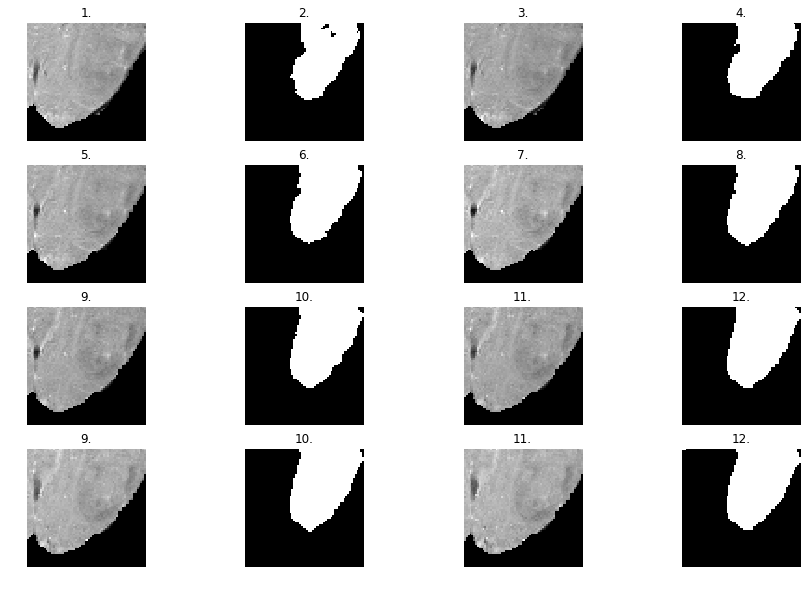

In [109]:
#print for a batch

plt.figure(figsize=(15,10))
axial = 0
num = 4


plt.subplot(441)
plt.title('1.')
plt.axis('off')
plt.imshow(patches[num, axial, :, :],cmap='gray')

plt.subplot(442)
plt.title('2.')
plt.axis('off')
plt.imshow(patches_label[num, axial, :, :], cmap='gray')

axial += 1

plt.subplot(443)
plt.title('3.')
plt.axis('off')
plt.imshow(patches[num, axial, :, :],cmap='gray')

plt.subplot(444)
plt.title('4.')
plt.axis('off')
plt.imshow(patches_label[num, axial, :, :], cmap='gray')

axial += 1

plt.subplot(445)
plt.title('5.')
plt.axis('off')
plt.imshow(patches[num, axial, :, :],cmap='gray')

plt.subplot(446)
plt.title('6.')
plt.axis('off')
plt.imshow(patches_label[num, axial, :, :],cmap='gray')

axial += 1

plt.subplot(447)
plt.title('7.')
plt.axis('off')
plt.imshow(patches[num, axial, :, :],cmap='gray')

plt.subplot(448)
plt.title('8.')
plt.axis('off')
plt.imshow(patches_label[num, axial, :, :],cmap='gray')

axial += 1

plt.subplot(449)
plt.title('9.')
plt.axis('off')
plt.imshow(patches[num, axial, :, :],cmap='gray')

plt.subplot(4,4,10)
plt.title('10.')
plt.axis('off')
plt.imshow(patches_label[num, axial, :, :],cmap='gray')

axial += 1

plt.subplot(4,4,11)
plt.title('11.')
plt.axis('off')
plt.imshow(patches[num, axial, :, :],cmap='gray')

plt.subplot(4,4,12)
plt.title('12.')
plt.axis('off')
plt.imshow(patches_label[num, axial, :, :],cmap='gray')


axial += 1

plt.subplot(4,4,13)
plt.title('9.')
plt.axis('off')
plt.imshow(patches[num, axial, :, :],cmap='gray')

plt.subplot(4,4,14)
plt.title('10.')
plt.axis('off')
plt.imshow(patches_label[num, axial, :, :],cmap='gray')

axial += 1

plt.subplot(4,4,15)
plt.title('11.')
plt.axis('off')
plt.imshow(patches[num, axial, :, :],cmap='gray')

plt.subplot(4,4,16)
plt.title('12.')
plt.axis('off')
plt.imshow(patches_label[num, axial, :, :],cmap='gray')

plt.show()

In [11]:
#a 3D kepek kimentese nii.gz fileba

pic_num = 10
img_from = pic_num-1
img_until = pic_num
img, label_full = t2_flair_load('D:/Diplomamunka/adatok/', '**/*.nii.gz', img_from, img_until)

numpy_to_nifti(img[0,0,:,:,:], file_name = 'test11')
#save_numpy_2_nifti(image_numpy=img, reference_nifti_filepath='', reference_affine=None, output_filepath=[])

Processing--- D:/Diplomamunka/adatok\imagesTr\BRATS_010.nii.gz
Processing--- D:/Diplomamunka/adatok\labelsTr\BRATS_010.nii.gz


In [10]:
def numpy_to_nifti(array, file_name):
    
    data = array
    root = 'D:/Diplomamunka'
    name = file_name + '.nii.gz'
    
    #data = np.rot90(data, 1,axes=(-2,-1))
    #data = np.rot90(data, 1,axes=(1,0))
    
    img = nib.Nifti1Image(data, np.eye(4))  # Save axis for data (just identity)

    img.header.get_xyzt_units()
    img.to_filename(os.path.join(root ,name)) 
    

In [ ]:
def connected_components(array,):
    matrix = array
    structure = np.ones((3,3), dtype=np.int)
    
    labeled, ncomponents = label(matrix, structure)

In [ ]:
def test_a_picture_dice(pic_num,size):
    
    img_from = pic_num-1
    img_until = pic_num
    #img_full, label_full = t2_flair_load('D:/KBence/BRATS16_17/', '**/*.nii.gz', img_from, img_until)
    img_full, label_full = t2_flair_load('D:/Diplomamunka/adatok/', '**/*.nii.gz', img_from, img_until)
    
    crop_img, crop_label = crop(image = img_full[0,:,:,:,:], label = label_full[0,:,:,:])
    
    test_img, test_label, size = split_cube(input_img = crop_img, input_label = crop_label, shape=shape)
    
    num_of_cubes, mod, z, x, y = test_img.shape
    
    pre = np.zeros((1,2,16,16,16))
    
    full_pred = np.zeros((num_of_cubes,16,16,16))
    
    for i in range (0, num_of_cubes):
        
        pre[0,:,:,:,:] = test_img[i,:,:,:,:]
        
        predicted = model.predict(pre)
        
        print('predicted: ', predicted.shape)
        
        full_pred[i,:,:,:] = predicted[0,0,:,:,:]
        
        
    prediction_3D = join_cubes (cubes = full_pred, size = size)
    
    
    dice = dice_coef_loss(test_label, prediction_3D)
    
    
    return dice